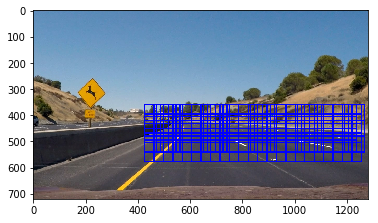

In [ ]:
# Main file for the project
import glob
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

# Now to detect images, get the frame, iterate (windows) then check if there is a car in the box!
# test car detection on test images
from utilities import slide_window, draw_boxes
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
# Train network
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from utilities import draw_boxes, extract_features, add_heat, apply_threshold, draw_labeled_bboxes
from time import time
import PIL

plt.interactive(False)
# Prepare data, first read images of cars and not cars, then extract features,
# the labels will just be a 1 for CAR and a 0 for "NOT CAR"

# Read images from dataset
# Small dataset
#img_cars_files = glob.glob("dataset\\vehicles_smallset\\**\\*.jpeg",recursive= True)
#img_notcars_files = glob.glob("dataset\\non-vehicles_smallset\\**\\*.jpeg",recursive= True)
# Large dataset
img_cars_files = glob.glob("dataset\\vehicles\\**\\*.png",recursive= True)
img_notcars_files = glob.glob("dataset\\non-vehicles\\**\\*.png",recursive= True)

img_cars = []
img_not_cars = []
for image_file in img_cars_files:
    img_cars.append(image_file)
for image_file in img_notcars_files:
    img_not_cars.append(image_file)

# Extract features from images of cars and not-cars
car_features = extract_features(img_cars)
notcar_features = extract_features(img_not_cars)

X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Create corresponding labels
y = np.hstack((np.ones(len(car_features)),
              np.zeros(len(notcar_features))))
n_classes = 2

## Split dataset into training and test set
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# Scale features
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X_train and X_test
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

########## Use GridSearchCV to find good parameters for SV classifier #############
# Check the training time for the SVC
# GridSeachCV Is very slow, but I can use it to find the best parameters for SVC
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100], }
#parameters = [
#  {'C': [1, 10, 100], 'kernel': ['linear']},
#  {'C': [1, 10, 100], 'gamma': [0.001, 0.0001, 0.00001], 'degree': [2, 3, 4], 'kernel': ['rbf']},
# ]
#clf = GridSearchCV(svc, parameters, return_train_score=False, n_jobs=8)
#print("Best estimator found by grid search:")
#print(clf.best_estimator_)
###################################################################################

# Classifier with parameter set found via GridSearchCV
clf = svm.SVC(C=10, cache_size=1000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.005, verbose=False)

print("Fitting the classifier to the training set")
t0 = time()
clf.fit(scaled_X_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting...")
t0 = time()
y_pred = clf.predict(scaled_X_test)
print("done in %0.3fs" % (time() - t0))

print("Classification report")
print(classification_report(y_test, y_pred, target_names=['Car','Not Car']))

print("Confusion matrix")
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


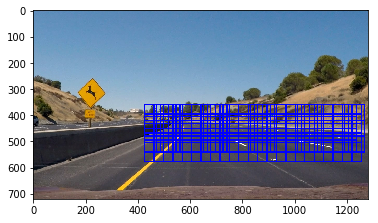

In [30]:
def detect_cars(frame):
    detected_windows = []
    # Classification step
    X_show = True
    for window in windows:
        cropped_fig = frame[window[0][1]:window[1][1], window[0][0]:window[1][0]]
        # need to resize to a 64 by 64 image to classify
        dst = cv2.resize(cropped_fig, (64, 64), interpolation=cv2.INTER_NEAREST)
        # Classify
        X = extract_features(dst,
                             c_space='YUV',
                             spatial_size=(32, 32),
                             hist_bins=32,
                             hist_range=(0, 256),
                             hog_channels=2,
                             hog_orient=11,
                             hog_pix_per_cell=16,
                             hog_cell_per_block=2)
        # Apply the scaler to X_train and X_test
        scaled_X = X_scaler.transform([np.array(X)])
        Y_pred = clf.predict(scaled_X)
        if X_show:
            #print("Mean Std X: {}, {}".format(np.mean(X), np.std(X)))
            #print("Scald MS X: {}, {}".format(np.mean(scaled_X), np.std(scaled_X)))
            X_show = False
        if Y_pred:
            detected_windows.append(window)
            # cv2.rectangle(frame, (window[0][0],window[1][0]),(window[0][1],window[1][1]), (0, 0, 255), 6)

    heat = np.zeros_like(frame[:, :, 0]).astype(np.float)
    # Add heat to each box in box list
    heatmap = add_heat(heat, detected_windows)

    # Apply threshold to help remove false positives
    heatmap = apply_threshold(heatmap, threshold=1)

    # Clip heatmap
    heatmap = np.clip(heatmap, 0, 255)
    #print(np.amin(heatmap))
    #print(np.amax(heatmap))
    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    draw_img = draw_labeled_bboxes(np.copy(frame), labels)

    heatmap *= 255
    heatmap = np.uint8(np.clip(heatmap, 0, 255))

    # Add heatmap to frame (top left corner)
    img_w, img_h = (320, 240)
    bg_w, bg_h = (1280, 720)
    offset = ((bg_w - img_w) // 8, (bg_h - img_h) // 8)
    heatmap_small = cv2.resize(heatmap, (320, 240))
    heatmap_small_pip = PIL.Image.fromarray(heatmap_small)

    draw_img_pip = PIL.Image.fromarray(draw_img)
    draw_img_pip.paste(heatmap_small_pip, offset)
    draw_img_return = np.array(draw_img_pip)
    # draw_img = draw_boxes(frame, detected_windows, thickness=3)
    return draw_img_return

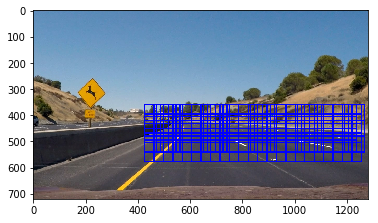

In [36]:
# Define windows where to search

test_image = mpimg.imread("test_images\\test2.jpg")
img = np.zeros_like(test_image,dtype= np.uint8)
windows = slide_window(img,
                       (int(test_image.shape[1]*1/3), test_image.shape[1]),
                       (int(test_image.shape[0] / 2), int(test_image.shape[0]*8/10)),
                       xy_window=(int(test_image.shape[0] / 4), int(test_image.shape[0] / 4)))

for den in [6, 8, 10]:
    windows += slide_window(test_image,
                            (int(test_image.shape[1]*1/3), test_image.shape[1]),
                            (int(test_image.shape[0] / 2), int(test_image.shape[0]*8/10)),
                            xy_window=(int(test_image.shape[0] / den), int(test_image.shape[0] / den)))

# Explore data
imcopy = draw_boxes(test_image, windows, thickness=3)
plt.figure()
plt.imshow(imcopy)
plt.show()


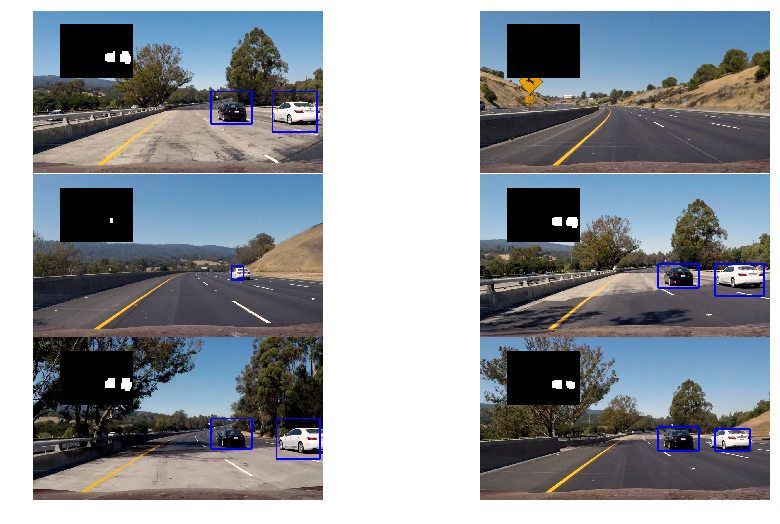

In [35]:
# Test algorithm on test images

test_images = glob.glob('./test_images/test*.jpg')
plt.interactive(False)
fig, axs = plt.subplots(3, 2, figsize=(16,9))
fig.subplots_adjust(hspace = .004, wspace=.004)
axs = axs.ravel()

for i, im in enumerate(test_images[0:6]):
    axs[i].imshow(detect_cars(mpimg.imread(im)))
    axs[i].axis('off')
plt.show()


In [34]:
# Generate video output
timestr = time.strftime("%Y%m%d-%H%M%S")
print("Generating video output!")
project_video_output = 'project_video_out-' + timestr + '.mp4'
clip = VideoFileClip('project_video3.mp4')
out_clip = clip.fl_image(detect_cars)
print("Writing video output to file...")
out_clip.write_videofile(project_video_output, audio=False)
print("Done")
import os
os.startfile(project_video_output)


Generating video output!

Writing video output to file...

[MoviePy] >>>> Building video project_video_out-20180520-155757.mp4


[MoviePy] Writing video project_video_out-20180520-155757.mp4


  0%|                                                    | 0/1261 [00:00<?, ?it/s]

  0%|                                            | 1/1261 [00:02<56:24,  2.69s/it]

  0%|                                            | 2/1261 [00:05<56:13,  2.68s/it]

  0%|                                            | 3/1261 [00:08<56:07,  2.68s/it]

  0%|▏                                           | 4/1261 [00:10<56:04,  2.68s/it]

  0%|▏                                           | 5/1261 [00:13<56:01,  2.68s/it]

  0%|▏                                           | 6/1261 [00:16<57:22,  2.74s/it]

  1%|▏                                           | 7/1261 [00:19<57:50,  2.77s/it]

  1%|▎                                           | 8/1261 [00:22<58:01,  2.78s/it]

  1%|▎                                           | 9/1261 [00:25<58:08,  2.79s/it]

  1%|▎                                          | 10/1261 [00:27<58:18,  2.80s/it]

  1%|▍                                          | 11/1261 [00:30<58:16,  2.80s/it]

  1%|▍                                          | 12/1261 [00:33<58:13,  2.80s/it]

  1%|▍                                          | 13/1261 [00:36<58:12,  2.80s/it]

  1%|▍                                          | 14/1261 [00:39<58:04,  2.79s/it]

  1%|▌                                          | 15/1261 [00:41<58:01,  2.79s/it]

  1%|▌                                          | 16/1261 [00:44<57:55,  2.79s/it]

  1%|▌                                          | 17/1261 [00:47<57:49,  2.79s/it]

  1%|▌                                          | 18/1261 [00:50<57:45,  2.79s/it]

  2%|▋                                          | 19/1261 [00:52<57:41,  2.79s/it]

  2%|▋                                          | 20/1261 [00:55<57:36,  2.79s/it]

  2%|▋                                          | 21/1261 [00:58<57:32,  2.78s/it]

  2%|▊                                          | 22/1261 [01:01<57:30,  2.78s/it]

  2%|▊                                          | 23/1261 [01:04<57:30,  2.79s/it]

  2%|▊                                          | 24/1261 [01:06<57:26,  2.79s/it]

  2%|▊                                          | 25/1261 [01:09<57:21,  2.78s/it]

  2%|▉                                          | 26/1261 [01:12<57:17,  2.78s/it]

  2%|▉                                          | 27/1261 [01:15<57:14,  2.78s/it]

  2%|▉                                          | 28/1261 [01:17<57:13,  2.78s/it]

  2%|▉                                          | 29/1261 [01:20<57:11,  2.79s/it]

  2%|█                                          | 30/1261 [01:23<57:11,  2.79s/it]

  2%|█                                          | 31/1261 [01:26<57:13,  2.79s/it]

  3%|█                                          | 32/1261 [01:29<57:17,  2.80s/it]

  3%|█▏                                         | 33/1261 [01:32<57:15,  2.80s/it]

  3%|█▏                                         | 34/1261 [01:35<57:11,  2.80s/it]

  3%|█▏                                         | 35/1261 [01:37<57:09,  2.80s/it]

  3%|█▏                                         | 36/1261 [01:40<57:07,  2.80s/it]

  3%|█▎                                         | 37/1261 [01:43<57:05,  2.80s/it]

  3%|█▎                                         | 38/1261 [01:46<57:01,  2.80s/it]

  3%|█▎                                         | 39/1261 [01:49<56:58,  2.80s/it]

  3%|█▎                                         | 40/1261 [01:51<56:54,  2.80s/it]

  3%|█▍                                         | 41/1261 [01:54<56:50,  2.80s/it]

  3%|█▍                                         | 42/1261 [01:57<56:47,  2.80s/it]

  3%|█▍                                         | 43/1261 [02:00<56:49,  2.80s/it]

  3%|█▌                                         | 44/1261 [02:03<56:50,  2.80s/it]

  4%|█▌                                         | 45/1261 [02:06<56:46,  2.80s/it]

  4%|█▌                                         | 46/1261 [02:08<56:42,  2.80s/it]

  4%|█▌                                         | 47/1261 [02:11<56:41,  2.80s/it]

  4%|█▋                                         | 48/1261 [02:14<56:41,  2.80s/it]

  4%|█▋                                         | 49/1261 [02:17<56:44,  2.81s/it]

  4%|█▋                                         | 50/1261 [02:20<56:42,  2.81s/it]

  4%|█▋                                         | 51/1261 [02:23<56:38,  2.81s/it]

  4%|█▊                                         | 52/1261 [02:26<56:35,  2.81s/it]

  4%|█▊                                         | 53/1261 [02:28<56:31,  2.81s/it]

  4%|█▊                                         | 54/1261 [02:31<56:28,  2.81s/it]

  4%|█▉                                         | 55/1261 [02:34<56:24,  2.81s/it]

  4%|█▉                                         | 56/1261 [02:37<56:20,  2.81s/it]

  5%|█▉                                         | 57/1261 [02:39<56:17,  2.80s/it]

  5%|█▉                                         | 58/1261 [02:42<56:13,  2.80s/it]

  5%|██                                         | 59/1261 [02:46<56:30,  2.82s/it]

  5%|██                                         | 60/1261 [02:49<56:34,  2.83s/it]

  5%|██                                         | 61/1261 [02:52<56:32,  2.83s/it]

  5%|██                                         | 62/1261 [02:55<56:29,  2.83s/it]

  5%|██▏                                        | 63/1261 [02:58<56:25,  2.83s/it]

  5%|██▏                                        | 64/1261 [03:00<56:21,  2.83s/it]

  5%|██▏                                        | 65/1261 [03:03<56:17,  2.82s/it]

  5%|██▎                                        | 66/1261 [03:06<56:14,  2.82s/it]

  5%|██▎                                        | 67/1261 [03:09<56:10,  2.82s/it]

  5%|██▎                                        | 68/1261 [03:11<56:07,  2.82s/it]

  5%|██▎                                        | 69/1261 [03:14<56:04,  2.82s/it]

  6%|██▍                                        | 70/1261 [03:17<56:00,  2.82s/it]

  6%|██▍                                        | 71/1261 [03:20<55:57,  2.82s/it]

  6%|██▍                                        | 72/1261 [03:23<55:53,  2.82s/it]

  6%|██▍                                        | 73/1261 [03:25<55:50,  2.82s/it]

  6%|██▌                                        | 74/1261 [03:28<55:47,  2.82s/it]

  6%|██▌                                        | 75/1261 [03:31<55:43,  2.82s/it]

  6%|██▌                                        | 76/1261 [03:34<55:40,  2.82s/it]

  6%|██▋                                        | 77/1261 [03:36<55:36,  2.82s/it]

  6%|██▋                                        | 78/1261 [03:39<55:33,  2.82s/it]

  6%|██▋                                        | 79/1261 [03:42<55:29,  2.82s/it]

  6%|██▋                                        | 80/1261 [03:45<55:25,  2.82s/it]

  6%|██▊                                        | 81/1261 [03:48<55:22,  2.82s/it]

  7%|██▊                                        | 82/1261 [03:50<55:19,  2.82s/it]

  7%|██▊                                        | 83/1261 [03:53<55:16,  2.82s/it]

  7%|██▊                                        | 84/1261 [03:56<55:12,  2.81s/it]

  7%|██▉                                        | 85/1261 [03:59<55:09,  2.81s/it]

  7%|██▉                                        | 86/1261 [04:01<55:05,  2.81s/it]

  7%|██▉                                        | 87/1261 [04:04<55:02,  2.81s/it]

  7%|███                                        | 88/1261 [04:07<54:59,  2.81s/it]

  7%|███                                        | 89/1261 [04:10<54:55,  2.81s/it]

  7%|███                                        | 90/1261 [04:13<54:52,  2.81s/it]

  7%|███                                        | 91/1261 [04:15<54:49,  2.81s/it]

  7%|███▏                                       | 92/1261 [04:18<54:46,  2.81s/it]

  7%|███▏                                       | 93/1261 [04:21<54:43,  2.81s/it]

  7%|███▏                                       | 94/1261 [04:24<54:40,  2.81s/it]

  8%|███▏                                       | 95/1261 [04:27<54:37,  2.81s/it]

  8%|███▎                                       | 96/1261 [04:29<54:33,  2.81s/it]

  8%|███▎                                       | 97/1261 [04:32<54:30,  2.81s/it]

  8%|███▎                                       | 98/1261 [04:35<54:27,  2.81s/it]

  8%|███▍                                       | 99/1261 [04:38<54:23,  2.81s/it]

  8%|███▎                                      | 100/1261 [04:40<54:20,  2.81s/it]

  8%|███▎                                      | 101/1261 [04:43<54:16,  2.81s/it]

  8%|███▍                                      | 102/1261 [04:46<54:13,  2.81s/it]

  8%|███▍                                      | 103/1261 [04:49<54:10,  2.81s/it]

  8%|███▍                                      | 104/1261 [04:51<54:07,  2.81s/it]

  8%|███▍                                      | 105/1261 [04:54<54:03,  2.81s/it]

  8%|███▌                                      | 106/1261 [04:57<54:00,  2.81s/it]

  8%|███▌                                      | 107/1261 [05:00<53:57,  2.81s/it]

  9%|███▌                                      | 108/1261 [05:02<53:53,  2.80s/it]

  9%|███▋                                      | 109/1261 [05:05<53:50,  2.80s/it]

  9%|███▋                                      | 110/1261 [05:08<53:47,  2.80s/it]

  9%|███▋                                      | 111/1261 [05:11<53:43,  2.80s/it]

  9%|███▋                                      | 112/1261 [05:13<53:40,  2.80s/it]

  9%|███▊                                      | 113/1261 [05:16<53:37,  2.80s/it]

  9%|███▊                                      | 114/1261 [05:19<53:34,  2.80s/it]

  9%|███▊                                      | 115/1261 [05:22<53:31,  2.80s/it]

  9%|███▊                                      | 116/1261 [05:25<53:28,  2.80s/it]

  9%|███▉                                      | 117/1261 [05:27<53:25,  2.80s/it]

  9%|███▉                                      | 118/1261 [05:30<53:22,  2.80s/it]

  9%|███▉                                      | 119/1261 [05:33<53:18,  2.80s/it]

 10%|███▉                                      | 120/1261 [05:36<53:15,  2.80s/it]

 10%|████                                      | 121/1261 [05:38<53:12,  2.80s/it]

 10%|████                                      | 122/1261 [05:41<53:09,  2.80s/it]

 10%|████                                      | 123/1261 [05:44<53:06,  2.80s/it]

 10%|████▏                                     | 124/1261 [05:47<53:03,  2.80s/it]

 10%|████▏                                     | 125/1261 [05:49<53:00,  2.80s/it]

 10%|████▏                                     | 126/1261 [05:52<52:57,  2.80s/it]

 10%|████▏                                     | 127/1261 [05:55<52:54,  2.80s/it]

 10%|████▎                                     | 128/1261 [05:58<52:50,  2.80s/it]

 10%|████▎                                     | 129/1261 [06:01<52:47,  2.80s/it]

 10%|████▎                                     | 130/1261 [06:03<52:44,  2.80s/it]

 10%|████▎                                     | 131/1261 [06:06<52:41,  2.80s/it]

 10%|████▍                                     | 132/1261 [06:09<52:38,  2.80s/it]

 11%|████▍                                     | 133/1261 [06:12<52:35,  2.80s/it]

 11%|████▍                                     | 134/1261 [06:14<52:32,  2.80s/it]

 11%|████▍                                     | 135/1261 [06:17<52:29,  2.80s/it]

 11%|████▌                                     | 136/1261 [06:20<52:26,  2.80s/it]

 11%|████▌                                     | 137/1261 [06:23<52:22,  2.80s/it]

 11%|████▌                                     | 138/1261 [06:25<52:19,  2.80s/it]

 11%|████▋                                     | 139/1261 [06:28<52:16,  2.80s/it]

 11%|████▋                                     | 140/1261 [06:31<52:13,  2.80s/it]

 11%|████▋                                     | 141/1261 [06:34<52:10,  2.80s/it]

 11%|████▋                                     | 142/1261 [06:36<52:07,  2.79s/it]

 11%|████▊                                     | 143/1261 [06:39<52:04,  2.79s/it]

 11%|████▊                                     | 144/1261 [06:42<52:01,  2.79s/it]

 11%|████▊                                     | 145/1261 [06:45<51:58,  2.79s/it]

 12%|████▊                                     | 146/1261 [06:47<51:55,  2.79s/it]

 12%|████▉                                     | 147/1261 [06:50<51:52,  2.79s/it]

 12%|████▉                                     | 148/1261 [06:53<51:49,  2.79s/it]

 12%|████▉                                     | 149/1261 [06:56<51:46,  2.79s/it]

 12%|████▉                                     | 150/1261 [06:58<51:43,  2.79s/it]

 12%|█████                                     | 151/1261 [07:01<51:40,  2.79s/it]

 12%|█████                                     | 152/1261 [07:04<51:37,  2.79s/it]

 12%|█████                                     | 153/1261 [07:07<51:34,  2.79s/it]

 12%|█████▏                                    | 154/1261 [07:10<51:31,  2.79s/it]

 12%|█████▏                                    | 155/1261 [07:12<51:28,  2.79s/it]

 12%|█████▏                                    | 156/1261 [07:15<51:25,  2.79s/it]

 12%|█████▏                                    | 157/1261 [07:18<51:22,  2.79s/it]

 13%|█████▎                                    | 158/1261 [07:21<51:19,  2.79s/it]

 13%|█████▎                                    | 159/1261 [07:23<51:16,  2.79s/it]

 13%|█████▎                                    | 160/1261 [07:26<51:13,  2.79s/it]

 13%|█████▎                                    | 161/1261 [07:29<51:10,  2.79s/it]

 13%|█████▍                                    | 162/1261 [07:32<51:07,  2.79s/it]

 13%|█████▍                                    | 163/1261 [07:35<51:05,  2.79s/it]

 13%|█████▍                                    | 164/1261 [07:37<51:02,  2.79s/it]

 13%|█████▍                                    | 165/1261 [07:40<50:59,  2.79s/it]

 13%|█████▌                                    | 166/1261 [07:43<50:56,  2.79s/it]

 13%|█████▌                                    | 167/1261 [07:46<50:53,  2.79s/it]

 13%|█████▌                                    | 168/1261 [07:48<50:50,  2.79s/it]

 13%|█████▋                                    | 169/1261 [07:51<50:47,  2.79s/it]

 13%|█████▋                                    | 170/1261 [07:54<50:44,  2.79s/it]

 14%|█████▋                                    | 171/1261 [07:57<50:41,  2.79s/it]

 14%|█████▋                                    | 172/1261 [07:59<50:38,  2.79s/it]

 14%|█████▊                                    | 173/1261 [08:02<50:35,  2.79s/it]

 14%|█████▊                                    | 174/1261 [08:05<50:32,  2.79s/it]

 14%|█████▊                                    | 175/1261 [08:08<50:29,  2.79s/it]

 14%|█████▊                                    | 176/1261 [08:10<50:26,  2.79s/it]

 14%|█████▉                                    | 177/1261 [08:13<50:24,  2.79s/it]

 14%|█████▉                                    | 178/1261 [08:16<50:21,  2.79s/it]

 14%|█████▉                                    | 179/1261 [08:19<50:19,  2.79s/it]

 14%|█████▉                                    | 180/1261 [08:22<50:16,  2.79s/it]

 14%|██████                                    | 181/1261 [08:25<50:13,  2.79s/it]

 14%|██████                                    | 182/1261 [08:27<50:11,  2.79s/it]

 15%|██████                                    | 183/1261 [08:30<50:08,  2.79s/it]

 15%|██████▏                                   | 184/1261 [08:33<50:05,  2.79s/it]

 15%|██████▏                                   | 185/1261 [08:36<50:02,  2.79s/it]

 15%|██████▏                                   | 186/1261 [08:39<49:59,  2.79s/it]

 15%|██████▏                                   | 187/1261 [08:41<49:57,  2.79s/it]

 15%|██████▎                                   | 188/1261 [08:44<49:54,  2.79s/it]

 15%|██████▎                                   | 189/1261 [08:47<49:51,  2.79s/it]

 15%|██████▎                                   | 190/1261 [08:50<49:48,  2.79s/it]

 15%|██████▎                                   | 191/1261 [08:52<49:45,  2.79s/it]

 15%|██████▍                                   | 192/1261 [08:55<49:42,  2.79s/it]

 15%|██████▍                                   | 193/1261 [08:58<49:40,  2.79s/it]

 15%|██████▍                                   | 194/1261 [09:01<49:37,  2.79s/it]

 15%|██████▍                                   | 195/1261 [09:04<49:34,  2.79s/it]

 16%|██████▌                                   | 196/1261 [09:06<49:31,  2.79s/it]

 16%|██████▌                                   | 197/1261 [09:09<49:28,  2.79s/it]

 16%|██████▌                                   | 198/1261 [09:12<49:25,  2.79s/it]

 16%|██████▋                                   | 199/1261 [09:15<49:22,  2.79s/it]

 16%|██████▋                                   | 200/1261 [09:17<49:18,  2.79s/it]

 16%|██████▋                                   | 201/1261 [09:20<49:16,  2.79s/it]

 16%|██████▋                                   | 202/1261 [09:23<49:12,  2.79s/it]

 16%|██████▊                                   | 203/1261 [09:25<49:09,  2.79s/it]

 16%|██████▊                                   | 204/1261 [09:28<49:05,  2.79s/it]

 16%|██████▊                                   | 205/1261 [09:31<49:02,  2.79s/it]

 16%|██████▊                                   | 206/1261 [09:33<48:58,  2.79s/it]

 16%|██████▉                                   | 207/1261 [09:36<48:55,  2.78s/it]

 16%|██████▉                                   | 208/1261 [09:39<48:51,  2.78s/it]

 17%|██████▉                                   | 209/1261 [09:41<48:48,  2.78s/it]

 17%|██████▉                                   | 210/1261 [09:44<48:44,  2.78s/it]

 17%|███████                                   | 211/1261 [09:46<48:40,  2.78s/it]

 17%|███████                                   | 212/1261 [09:49<48:37,  2.78s/it]

 17%|███████                                   | 213/1261 [09:52<48:33,  2.78s/it]

 17%|███████▏                                  | 214/1261 [09:54<48:29,  2.78s/it]

 17%|███████▏                                  | 215/1261 [09:57<48:26,  2.78s/it]

 17%|███████▏                                  | 216/1261 [10:00<48:22,  2.78s/it]

 17%|███████▏                                  | 217/1261 [10:02<48:19,  2.78s/it]

 17%|███████▎                                  | 218/1261 [10:05<48:16,  2.78s/it]

 17%|███████▎                                  | 219/1261 [10:07<48:12,  2.78s/it]

 17%|███████▎                                  | 220/1261 [10:10<48:09,  2.78s/it]

 18%|███████▎                                  | 221/1261 [10:13<48:05,  2.77s/it]

 18%|███████▍                                  | 222/1261 [10:15<48:01,  2.77s/it]

 18%|███████▍                                  | 223/1261 [10:18<47:58,  2.77s/it]

 18%|███████▍                                  | 224/1261 [10:21<47:54,  2.77s/it]

 18%|███████▍                                  | 225/1261 [10:23<47:51,  2.77s/it]

 18%|███████▌                                  | 226/1261 [10:26<47:48,  2.77s/it]

 18%|███████▌                                  | 227/1261 [10:28<47:44,  2.77s/it]

 18%|███████▌                                  | 228/1261 [10:31<47:41,  2.77s/it]

 18%|███████▋                                  | 229/1261 [10:34<47:37,  2.77s/it]

 18%|███████▋                                  | 230/1261 [10:36<47:34,  2.77s/it]

 18%|███████▋                                  | 231/1261 [10:39<47:30,  2.77s/it]

 18%|███████▋                                  | 232/1261 [10:41<47:27,  2.77s/it]

 18%|███████▊                                  | 233/1261 [10:44<47:24,  2.77s/it]

 19%|███████▊                                  | 234/1261 [10:47<47:20,  2.77s/it]

 19%|███████▊                                  | 235/1261 [10:49<47:17,  2.77s/it]

 19%|███████▊                                  | 236/1261 [10:52<47:13,  2.76s/it]

 19%|███████▉                                  | 237/1261 [10:55<47:11,  2.76s/it]

 19%|███████▉                                  | 238/1261 [10:57<47:08,  2.76s/it]

 19%|███████▉                                  | 239/1261 [11:00<47:04,  2.76s/it]

 19%|███████▉                                  | 240/1261 [11:03<47:01,  2.76s/it]

 19%|████████                                  | 241/1261 [11:05<46:57,  2.76s/it]

 19%|████████                                  | 242/1261 [11:08<46:54,  2.76s/it]

 19%|████████                                  | 243/1261 [11:11<46:51,  2.76s/it]

 19%|████████▏                                 | 244/1261 [11:13<46:47,  2.76s/it]

 19%|████████▏                                 | 245/1261 [11:16<46:44,  2.76s/it]

 20%|████████▏                                 | 246/1261 [11:18<46:41,  2.76s/it]

 20%|████████▏                                 | 247/1261 [11:21<46:37,  2.76s/it]

 20%|████████▎                                 | 248/1261 [11:24<46:34,  2.76s/it]

 20%|████████▎                                 | 249/1261 [11:26<46:30,  2.76s/it]

 20%|████████▎                                 | 250/1261 [11:29<46:27,  2.76s/it]

 20%|████████▎                                 | 251/1261 [11:31<46:24,  2.76s/it]

 20%|████████▍                                 | 252/1261 [11:34<46:21,  2.76s/it]

 20%|████████▍                                 | 253/1261 [11:37<46:17,  2.76s/it]

 20%|████████▍                                 | 254/1261 [11:39<46:14,  2.76s/it]

 20%|████████▍                                 | 255/1261 [11:42<46:11,  2.75s/it]

 20%|████████▌                                 | 256/1261 [11:45<46:07,  2.75s/it]

 20%|████████▌                                 | 257/1261 [11:47<46:04,  2.75s/it]

 20%|████████▌                                 | 258/1261 [11:50<46:01,  2.75s/it]

 21%|████████▋                                 | 259/1261 [11:52<45:57,  2.75s/it]

 21%|████████▋                                 | 260/1261 [11:55<45:54,  2.75s/it]

 21%|████████▋                                 | 261/1261 [11:58<45:51,  2.75s/it]

 21%|████████▋                                 | 262/1261 [12:00<45:48,  2.75s/it]

 21%|████████▊                                 | 263/1261 [12:03<45:45,  2.75s/it]

 21%|████████▊                                 | 264/1261 [12:06<45:42,  2.75s/it]

 21%|████████▊                                 | 265/1261 [12:08<45:38,  2.75s/it]

 21%|████████▊                                 | 266/1261 [12:11<45:35,  2.75s/it]

 21%|████████▉                                 | 267/1261 [12:13<45:32,  2.75s/it]

 21%|████████▉                                 | 268/1261 [12:16<45:29,  2.75s/it]

 21%|████████▉                                 | 269/1261 [12:19<45:25,  2.75s/it]

 21%|████████▉                                 | 270/1261 [12:21<45:22,  2.75s/it]

 21%|█████████                                 | 271/1261 [12:24<45:19,  2.75s/it]

 22%|█████████                                 | 272/1261 [12:26<45:16,  2.75s/it]

 22%|█████████                                 | 273/1261 [12:29<45:12,  2.75s/it]

 22%|█████████▏                                | 274/1261 [12:32<45:09,  2.75s/it]

 22%|█████████▏                                | 275/1261 [12:34<45:06,  2.74s/it]

 22%|█████████▏                                | 276/1261 [12:37<45:03,  2.74s/it]

 22%|█████████▏                                | 277/1261 [12:40<44:59,  2.74s/it]

 22%|█████████▎                                | 278/1261 [12:42<44:56,  2.74s/it]

 22%|█████████▎                                | 279/1261 [12:45<44:53,  2.74s/it]

 22%|█████████▎                                | 280/1261 [12:47<44:50,  2.74s/it]

 22%|█████████▎                                | 281/1261 [12:50<44:47,  2.74s/it]

 22%|█████████▍                                | 282/1261 [12:53<44:43,  2.74s/it]

 22%|█████████▍                                | 283/1261 [12:55<44:40,  2.74s/it]

 23%|█████████▍                                | 284/1261 [12:58<44:37,  2.74s/it]

 23%|█████████▍                                | 285/1261 [13:00<44:34,  2.74s/it]

 23%|█████████▌                                | 286/1261 [13:03<44:31,  2.74s/it]

 23%|█████████▌                                | 287/1261 [13:06<44:27,  2.74s/it]

 23%|█████████▌                                | 288/1261 [13:08<44:24,  2.74s/it]

 23%|█████████▋                                | 289/1261 [13:11<44:21,  2.74s/it]

 23%|█████████▋                                | 290/1261 [13:13<44:18,  2.74s/it]

 23%|█████████▋                                | 291/1261 [13:16<44:15,  2.74s/it]

 23%|█████████▋                                | 292/1261 [13:19<44:12,  2.74s/it]

 23%|█████████▊                                | 293/1261 [13:21<44:08,  2.74s/it]

 23%|█████████▊                                | 294/1261 [13:24<44:05,  2.74s/it]

 23%|█████████▊                                | 295/1261 [13:27<44:02,  2.74s/it]

 23%|█████████▊                                | 296/1261 [13:29<43:59,  2.74s/it]

 24%|█████████▉                                | 297/1261 [13:32<43:56,  2.73s/it]

 24%|█████████▉                                | 298/1261 [13:34<43:53,  2.73s/it]

 24%|█████████▉                                | 299/1261 [13:37<43:50,  2.73s/it]

 24%|█████████▉                                | 300/1261 [13:40<43:47,  2.73s/it]

 24%|██████████                                | 301/1261 [13:42<43:43,  2.73s/it]

 24%|██████████                                | 302/1261 [13:45<43:40,  2.73s/it]

 24%|██████████                                | 303/1261 [13:47<43:37,  2.73s/it]

 24%|██████████▏                               | 304/1261 [13:50<43:34,  2.73s/it]

 24%|██████████▏                               | 305/1261 [13:53<43:31,  2.73s/it]

 24%|██████████▏                               | 306/1261 [13:55<43:28,  2.73s/it]

 24%|██████████▏                               | 307/1261 [13:58<43:25,  2.73s/it]

 24%|██████████▎                               | 308/1261 [14:00<43:22,  2.73s/it]

 25%|██████████▎                               | 309/1261 [14:03<43:18,  2.73s/it]

 25%|██████████▎                               | 310/1261 [14:06<43:15,  2.73s/it]

 25%|██████████▎                               | 311/1261 [14:08<43:12,  2.73s/it]

 25%|██████████▍                               | 312/1261 [14:11<43:09,  2.73s/it]

 25%|██████████▍                               | 313/1261 [14:13<43:06,  2.73s/it]

 25%|██████████▍                               | 314/1261 [14:16<43:03,  2.73s/it]

 25%|██████████▍                               | 315/1261 [14:19<43:00,  2.73s/it]

 25%|██████████▌                               | 316/1261 [14:21<42:57,  2.73s/it]

 25%|██████████▌                               | 317/1261 [14:24<42:54,  2.73s/it]

 25%|██████████▌                               | 318/1261 [14:27<42:51,  2.73s/it]

 25%|██████████▌                               | 319/1261 [14:29<42:47,  2.73s/it]

 25%|██████████▋                               | 320/1261 [14:32<42:44,  2.73s/it]

 25%|██████████▋                               | 321/1261 [14:34<42:41,  2.73s/it]

 26%|██████████▋                               | 322/1261 [14:37<42:38,  2.73s/it]

 26%|██████████▊                               | 323/1261 [14:40<42:35,  2.72s/it]

 26%|██████████▊                               | 324/1261 [14:42<42:32,  2.72s/it]

 26%|██████████▊                               | 325/1261 [14:45<42:29,  2.72s/it]

 26%|██████████▊                               | 326/1261 [14:47<42:26,  2.72s/it]

 26%|██████████▉                               | 327/1261 [14:50<42:23,  2.72s/it]

 26%|██████████▉                               | 328/1261 [14:53<42:20,  2.72s/it]

 26%|██████████▉                               | 329/1261 [14:55<42:17,  2.72s/it]

 26%|██████████▉                               | 330/1261 [14:58<42:14,  2.72s/it]

 26%|███████████                               | 331/1261 [15:00<42:11,  2.72s/it]

 26%|███████████                               | 332/1261 [15:03<42:08,  2.72s/it]

 26%|███████████                               | 333/1261 [15:06<42:05,  2.72s/it]

 26%|███████████                               | 334/1261 [15:08<42:02,  2.72s/it]

 27%|███████████▏                              | 335/1261 [15:11<41:59,  2.72s/it]

 27%|███████████▏                              | 336/1261 [15:13<41:56,  2.72s/it]

 27%|███████████▏                              | 337/1261 [15:16<41:53,  2.72s/it]

 27%|███████████▎                              | 338/1261 [15:19<41:50,  2.72s/it]

 27%|███████████▎                              | 339/1261 [15:21<41:47,  2.72s/it]

 27%|███████████▎                              | 340/1261 [15:24<41:44,  2.72s/it]

 27%|███████████▎                              | 341/1261 [15:27<41:41,  2.72s/it]

 27%|███████████▍                              | 342/1261 [15:29<41:37,  2.72s/it]

 27%|███████████▍                              | 343/1261 [15:32<41:34,  2.72s/it]

 27%|███████████▍                              | 344/1261 [15:34<41:31,  2.72s/it]

 27%|███████████▍                              | 345/1261 [15:37<41:28,  2.72s/it]

 27%|███████████▌                              | 346/1261 [15:40<41:25,  2.72s/it]

 28%|███████████▌                              | 347/1261 [15:42<41:22,  2.72s/it]

 28%|███████████▌                              | 348/1261 [15:45<41:19,  2.72s/it]

 28%|███████████▌                              | 349/1261 [15:47<41:16,  2.72s/it]

 28%|███████████▋                              | 350/1261 [15:50<41:13,  2.72s/it]

 28%|███████████▋                              | 351/1261 [15:53<41:10,  2.72s/it]

 28%|███████████▋                              | 352/1261 [15:55<41:07,  2.72s/it]

 28%|███████████▊                              | 353/1261 [15:58<41:04,  2.71s/it]

 28%|███████████▊                              | 354/1261 [16:00<41:01,  2.71s/it]

 28%|███████████▊                              | 355/1261 [16:03<40:58,  2.71s/it]

 28%|███████████▊                              | 356/1261 [16:06<40:55,  2.71s/it]

 28%|███████████▉                              | 357/1261 [16:08<40:52,  2.71s/it]

 28%|███████████▉                              | 358/1261 [16:11<40:49,  2.71s/it]

 28%|███████████▉                              | 359/1261 [16:13<40:46,  2.71s/it]

 29%|███████████▉                              | 360/1261 [16:16<40:44,  2.71s/it]

 29%|████████████                              | 361/1261 [16:19<40:41,  2.71s/it]

 29%|████████████                              | 362/1261 [16:21<40:38,  2.71s/it]

 29%|████████████                              | 363/1261 [16:24<40:35,  2.71s/it]

 29%|████████████                              | 364/1261 [16:26<40:32,  2.71s/it]

 29%|████████████▏                             | 365/1261 [16:29<40:29,  2.71s/it]

 29%|████████████▏                             | 366/1261 [16:32<40:26,  2.71s/it]

 29%|████████████▏                             | 367/1261 [16:34<40:23,  2.71s/it]

 29%|████████████▎                             | 368/1261 [16:37<40:20,  2.71s/it]

 29%|████████████▎                             | 369/1261 [16:39<40:17,  2.71s/it]

 29%|████████████▎                             | 370/1261 [16:42<40:14,  2.71s/it]

 29%|████████████▎                             | 371/1261 [16:45<40:11,  2.71s/it]

 30%|████████████▍                             | 372/1261 [16:47<40:08,  2.71s/it]

 30%|████████████▍                             | 373/1261 [16:50<40:05,  2.71s/it]

 30%|████████████▍                             | 374/1261 [16:52<40:02,  2.71s/it]

 30%|████████████▍                             | 375/1261 [16:55<39:59,  2.71s/it]

 30%|████████████▌                             | 376/1261 [16:58<39:56,  2.71s/it]

 30%|████████████▌                             | 377/1261 [17:00<39:53,  2.71s/it]

 30%|████████████▌                             | 378/1261 [17:03<39:50,  2.71s/it]

 30%|████████████▌                             | 379/1261 [17:06<39:47,  2.71s/it]

 30%|████████████▋                             | 380/1261 [17:08<39:44,  2.71s/it]

 30%|████████████▋                             | 381/1261 [17:11<39:41,  2.71s/it]

 30%|████████████▋                             | 382/1261 [17:13<39:39,  2.71s/it]

 30%|████████████▊                             | 383/1261 [17:16<39:36,  2.71s/it]

 30%|████████████▊                             | 384/1261 [17:19<39:33,  2.71s/it]

 31%|████████████▊                             | 385/1261 [17:21<39:30,  2.71s/it]

 31%|████████████▊                             | 386/1261 [17:24<39:27,  2.71s/it]

 31%|████████████▉                             | 387/1261 [17:26<39:24,  2.71s/it]

 31%|████████████▉                             | 388/1261 [17:29<39:21,  2.71s/it]

 31%|████████████▉                             | 389/1261 [17:32<39:18,  2.70s/it]

 31%|████████████▉                             | 390/1261 [17:34<39:15,  2.70s/it]

 31%|█████████████                             | 391/1261 [17:37<39:12,  2.70s/it]

 31%|█████████████                             | 392/1261 [17:39<39:09,  2.70s/it]

 31%|█████████████                             | 393/1261 [17:42<39:06,  2.70s/it]

 31%|█████████████                             | 394/1261 [17:45<39:03,  2.70s/it]

 31%|█████████████▏                            | 395/1261 [17:47<39:00,  2.70s/it]

 31%|█████████████▏                            | 396/1261 [17:50<38:58,  2.70s/it]

 31%|█████████████▏                            | 397/1261 [17:52<38:55,  2.70s/it]

 32%|█████████████▎                            | 398/1261 [17:55<38:52,  2.70s/it]

 32%|█████████████▎                            | 399/1261 [17:58<38:49,  2.70s/it]

 32%|█████████████▎                            | 400/1261 [18:00<38:46,  2.70s/it]

 32%|█████████████▎                            | 401/1261 [18:03<38:43,  2.70s/it]

 32%|█████████████▍                            | 402/1261 [18:05<38:40,  2.70s/it]

 32%|█████████████▍                            | 403/1261 [18:08<38:37,  2.70s/it]

 32%|█████████████▍                            | 404/1261 [18:11<38:34,  2.70s/it]

 32%|█████████████▍                            | 405/1261 [18:13<38:31,  2.70s/it]

 32%|█████████████▌                            | 406/1261 [18:16<38:28,  2.70s/it]

 32%|█████████████▌                            | 407/1261 [18:19<38:26,  2.70s/it]

 32%|█████████████▌                            | 408/1261 [18:21<38:23,  2.70s/it]

 32%|█████████████▌                            | 409/1261 [18:24<38:20,  2.70s/it]

 33%|█████████████▋                            | 410/1261 [18:26<38:17,  2.70s/it]

 33%|█████████████▋                            | 411/1261 [18:29<38:14,  2.70s/it]

 33%|█████████████▋                            | 412/1261 [18:32<38:11,  2.70s/it]

 33%|█████████████▊                            | 413/1261 [18:34<38:08,  2.70s/it]

 33%|█████████████▊                            | 414/1261 [18:37<38:05,  2.70s/it]

 33%|█████████████▊                            | 415/1261 [18:39<38:02,  2.70s/it]

 33%|█████████████▊                            | 416/1261 [18:42<38:00,  2.70s/it]

 33%|█████████████▉                            | 417/1261 [18:45<37:57,  2.70s/it]

 33%|█████████████▉                            | 418/1261 [18:47<37:54,  2.70s/it]

 33%|█████████████▉                            | 419/1261 [18:50<37:51,  2.70s/it]

 33%|█████████████▉                            | 420/1261 [18:52<37:48,  2.70s/it]

 33%|██████████████                            | 421/1261 [18:55<37:45,  2.70s/it]

 33%|██████████████                            | 422/1261 [18:58<37:42,  2.70s/it]

 34%|██████████████                            | 423/1261 [19:00<37:39,  2.70s/it]

 34%|██████████████                            | 424/1261 [19:03<37:36,  2.70s/it]

 34%|██████████████▏                           | 425/1261 [19:05<37:34,  2.70s/it]

 34%|██████████████▏                           | 426/1261 [19:08<37:31,  2.70s/it]

 34%|██████████████▏                           | 427/1261 [19:11<37:28,  2.70s/it]

 34%|██████████████▎                           | 428/1261 [19:13<37:25,  2.70s/it]

 34%|██████████████▎                           | 429/1261 [19:16<37:22,  2.70s/it]

 34%|██████████████▎                           | 430/1261 [19:18<37:19,  2.70s/it]

 34%|██████████████▎                           | 431/1261 [19:21<37:16,  2.69s/it]

 34%|██████████████▍                           | 432/1261 [19:24<37:13,  2.69s/it]

 34%|██████████████▍                           | 433/1261 [19:26<37:10,  2.69s/it]

 34%|██████████████▍                           | 434/1261 [19:29<37:08,  2.69s/it]

 34%|██████████████▍                           | 435/1261 [19:31<37:05,  2.69s/it]

 35%|██████████████▌                           | 436/1261 [19:34<37:02,  2.69s/it]

 35%|██████████████▌                           | 437/1261 [19:37<36:59,  2.69s/it]

 35%|██████████████▌                           | 438/1261 [19:39<36:56,  2.69s/it]

 35%|██████████████▌                           | 439/1261 [19:42<36:53,  2.69s/it]

 35%|██████████████▋                           | 440/1261 [19:44<36:50,  2.69s/it]

 35%|██████████████▋                           | 441/1261 [19:47<36:47,  2.69s/it]

 35%|██████████████▋                           | 442/1261 [19:50<36:45,  2.69s/it]

 35%|██████████████▊                           | 443/1261 [19:52<36:42,  2.69s/it]

 35%|██████████████▊                           | 444/1261 [19:55<36:39,  2.69s/it]

 35%|██████████████▊                           | 445/1261 [19:57<36:36,  2.69s/it]

 35%|██████████████▊                           | 446/1261 [20:00<36:33,  2.69s/it]

 35%|██████████████▉                           | 447/1261 [20:03<36:30,  2.69s/it]

 36%|██████████████▉                           | 448/1261 [20:05<36:28,  2.69s/it]

 36%|██████████████▉                           | 449/1261 [20:08<36:25,  2.69s/it]

 36%|██████████████▉                           | 450/1261 [20:10<36:22,  2.69s/it]

 36%|███████████████                           | 451/1261 [20:13<36:19,  2.69s/it]

 36%|███████████████                           | 452/1261 [20:16<36:16,  2.69s/it]

 36%|███████████████                           | 453/1261 [20:18<36:13,  2.69s/it]

 36%|███████████████                           | 454/1261 [20:21<36:10,  2.69s/it]

 36%|███████████████▏                          | 455/1261 [20:23<36:08,  2.69s/it]

 36%|███████████████▏                          | 456/1261 [20:26<36:05,  2.69s/it]

 36%|███████████████▏                          | 457/1261 [20:29<36:02,  2.69s/it]

 36%|███████████████▎                          | 458/1261 [20:31<35:59,  2.69s/it]

 36%|███████████████▎                          | 459/1261 [20:34<35:56,  2.69s/it]

 36%|███████████████▎                          | 460/1261 [20:36<35:53,  2.69s/it]

 37%|███████████████▎                          | 461/1261 [20:39<35:51,  2.69s/it]

 37%|███████████████▍                          | 462/1261 [20:42<35:48,  2.69s/it]

 37%|███████████████▍                          | 463/1261 [20:44<35:45,  2.69s/it]

 37%|███████████████▍                          | 464/1261 [20:47<35:42,  2.69s/it]

 37%|███████████████▍                          | 465/1261 [20:50<35:39,  2.69s/it]

 37%|███████████████▌                          | 466/1261 [20:52<35:37,  2.69s/it]

 37%|███████████████▌                          | 467/1261 [20:55<35:34,  2.69s/it]

 37%|███████████████▌                          | 468/1261 [20:57<35:31,  2.69s/it]

 37%|███████████████▌                          | 469/1261 [21:00<35:28,  2.69s/it]

 37%|███████████████▋                          | 470/1261 [21:03<35:25,  2.69s/it]

 37%|███████████████▋                          | 471/1261 [21:05<35:22,  2.69s/it]

 37%|███████████████▋                          | 472/1261 [21:08<35:20,  2.69s/it]

 38%|███████████████▊                          | 473/1261 [21:10<35:17,  2.69s/it]

 38%|███████████████▊                          | 474/1261 [21:13<35:14,  2.69s/it]

 38%|███████████████▊                          | 475/1261 [21:16<35:11,  2.69s/it]

 38%|███████████████▊                          | 476/1261 [21:18<35:08,  2.69s/it]

 38%|███████████████▉                          | 477/1261 [21:21<35:06,  2.69s/it]

 38%|███████████████▉                          | 478/1261 [21:23<35:03,  2.69s/it]

 38%|███████████████▉                          | 479/1261 [21:26<35:00,  2.69s/it]

 38%|███████████████▉                          | 480/1261 [21:29<34:57,  2.69s/it]

 38%|████████████████                          | 481/1261 [21:31<34:54,  2.69s/it]

 38%|████████████████                          | 482/1261 [21:34<34:51,  2.69s/it]

 38%|████████████████                          | 483/1261 [21:36<34:49,  2.69s/it]

 38%|████████████████                          | 484/1261 [21:39<34:46,  2.69s/it]

 38%|████████████████▏                         | 485/1261 [21:42<34:43,  2.68s/it]

 39%|████████████████▏                         | 486/1261 [21:44<34:40,  2.68s/it]

 39%|████████████████▏                         | 487/1261 [21:47<34:37,  2.68s/it]

 39%|████████████████▎                         | 488/1261 [21:49<34:35,  2.68s/it]

 39%|████████████████▎                         | 489/1261 [21:52<34:32,  2.68s/it]

 39%|████████████████▎                         | 490/1261 [21:55<34:29,  2.68s/it]

 39%|████████████████▎                         | 491/1261 [21:57<34:26,  2.68s/it]

 39%|████████████████▍                         | 492/1261 [22:00<34:23,  2.68s/it]

 39%|████████████████▍                         | 493/1261 [22:02<34:20,  2.68s/it]

 39%|████████████████▍                         | 494/1261 [22:05<34:18,  2.68s/it]

 39%|████████████████▍                         | 495/1261 [22:08<34:15,  2.68s/it]

 39%|████████████████▌                         | 496/1261 [22:10<34:12,  2.68s/it]

 39%|████████████████▌                         | 497/1261 [22:13<34:09,  2.68s/it]

 39%|████████████████▌                         | 498/1261 [22:15<34:06,  2.68s/it]

 40%|████████████████▌                         | 499/1261 [22:18<34:04,  2.68s/it]

 40%|████████████████▋                         | 500/1261 [22:21<34:01,  2.68s/it]

 40%|████████████████▋                         | 501/1261 [22:23<33:58,  2.68s/it]

 40%|████████████████▋                         | 502/1261 [22:26<33:55,  2.68s/it]

 40%|████████████████▊                         | 503/1261 [22:28<33:52,  2.68s/it]

 40%|████████████████▊                         | 504/1261 [22:31<33:50,  2.68s/it]

 40%|████████████████▊                         | 505/1261 [22:34<33:47,  2.68s/it]

 40%|████████████████▊                         | 506/1261 [22:36<33:44,  2.68s/it]

 40%|████████████████▉                         | 507/1261 [22:39<33:41,  2.68s/it]

 40%|████████████████▉                         | 508/1261 [22:41<33:38,  2.68s/it]

 40%|████████████████▉                         | 509/1261 [22:44<33:36,  2.68s/it]

 40%|████████████████▉                         | 510/1261 [22:47<33:33,  2.68s/it]

 41%|█████████████████                         | 511/1261 [22:49<33:30,  2.68s/it]

 41%|█████████████████                         | 512/1261 [22:52<33:27,  2.68s/it]

 41%|█████████████████                         | 513/1261 [22:54<33:24,  2.68s/it]

 41%|█████████████████                         | 514/1261 [22:57<33:22,  2.68s/it]

 41%|█████████████████▏                        | 515/1261 [23:00<33:19,  2.68s/it]

 41%|█████████████████▏                        | 516/1261 [23:02<33:16,  2.68s/it]

 41%|█████████████████▏                        | 517/1261 [23:05<33:13,  2.68s/it]

 41%|█████████████████▎                        | 518/1261 [23:08<33:11,  2.68s/it]

 41%|█████████████████▎                        | 519/1261 [23:10<33:08,  2.68s/it]

 41%|█████████████████▎                        | 520/1261 [23:13<33:05,  2.68s/it]

 41%|█████████████████▎                        | 521/1261 [23:15<33:02,  2.68s/it]

 41%|█████████████████▍                        | 522/1261 [23:18<32:59,  2.68s/it]

 41%|█████████████████▍                        | 523/1261 [23:21<32:57,  2.68s/it]

 42%|█████████████████▍                        | 524/1261 [23:23<32:54,  2.68s/it]

 42%|█████████████████▍                        | 525/1261 [23:26<32:51,  2.68s/it]

 42%|█████████████████▌                        | 526/1261 [23:28<32:48,  2.68s/it]

 42%|█████████████████▌                        | 527/1261 [23:31<32:45,  2.68s/it]

 42%|█████████████████▌                        | 528/1261 [23:34<32:43,  2.68s/it]

 42%|█████████████████▌                        | 529/1261 [23:36<32:40,  2.68s/it]

 42%|█████████████████▋                        | 530/1261 [23:39<32:37,  2.68s/it]

 42%|█████████████████▋                        | 531/1261 [23:41<32:34,  2.68s/it]

 42%|█████████████████▋                        | 532/1261 [23:44<32:32,  2.68s/it]

 42%|█████████████████▊                        | 533/1261 [23:47<32:29,  2.68s/it]

 42%|█████████████████▊                        | 534/1261 [23:49<32:26,  2.68s/it]

 42%|█████████████████▊                        | 535/1261 [23:52<32:23,  2.68s/it]

 43%|█████████████████▊                        | 536/1261 [23:54<32:20,  2.68s/it]

 43%|█████████████████▉                        | 537/1261 [23:57<32:18,  2.68s/it]

 43%|█████████████████▉                        | 538/1261 [24:00<32:15,  2.68s/it]

 43%|█████████████████▉                        | 539/1261 [24:02<32:12,  2.68s/it]

 43%|█████████████████▉                        | 540/1261 [24:05<32:09,  2.68s/it]

 43%|██████████████████                        | 541/1261 [24:07<32:07,  2.68s/it]

 43%|██████████████████                        | 542/1261 [24:10<32:04,  2.68s/it]

 43%|██████████████████                        | 543/1261 [24:13<32:01,  2.68s/it]

 43%|██████████████████                        | 544/1261 [24:15<31:58,  2.68s/it]

 43%|██████████████████▏                       | 545/1261 [24:18<31:55,  2.68s/it]

 43%|██████████████████▏                       | 546/1261 [24:20<31:53,  2.68s/it]

 43%|██████████████████▏                       | 547/1261 [24:23<31:50,  2.68s/it]

 43%|██████████████████▎                       | 548/1261 [24:26<31:47,  2.68s/it]

 44%|██████████████████▎                       | 549/1261 [24:28<31:44,  2.68s/it]

 44%|██████████████████▎                       | 550/1261 [24:31<31:42,  2.68s/it]

 44%|██████████████████▎                       | 551/1261 [24:33<31:39,  2.68s/it]

 44%|██████████████████▍                       | 552/1261 [24:36<31:36,  2.67s/it]

 44%|██████████████████▍                       | 553/1261 [24:39<31:33,  2.67s/it]

 44%|██████████████████▍                       | 554/1261 [24:41<31:31,  2.67s/it]

 44%|██████████████████▍                       | 555/1261 [24:44<31:28,  2.67s/it]

 44%|██████████████████▌                       | 556/1261 [24:47<31:25,  2.67s/it]

 44%|██████████████████▌                       | 557/1261 [24:49<31:22,  2.67s/it]

 44%|██████████████████▌                       | 558/1261 [24:52<31:19,  2.67s/it]

 44%|██████████████████▌                       | 559/1261 [24:54<31:17,  2.67s/it]

 44%|██████████████████▋                       | 560/1261 [24:57<31:14,  2.67s/it]

 44%|██████████████████▋                       | 561/1261 [25:00<31:11,  2.67s/it]

 45%|██████████████████▋                       | 562/1261 [25:02<31:09,  2.67s/it]

 45%|██████████████████▊                       | 563/1261 [25:05<31:06,  2.67s/it]

 45%|██████████████████▊                       | 564/1261 [25:07<31:03,  2.67s/it]

 45%|██████████████████▊                       | 565/1261 [25:10<31:00,  2.67s/it]

 45%|██████████████████▊                       | 566/1261 [25:13<30:57,  2.67s/it]

 45%|██████████████████▉                       | 567/1261 [25:15<30:55,  2.67s/it]

 45%|██████████████████▉                       | 568/1261 [25:18<30:52,  2.67s/it]

 45%|██████████████████▉                       | 569/1261 [25:20<30:49,  2.67s/it]

 45%|██████████████████▉                       | 570/1261 [25:23<30:46,  2.67s/it]

 45%|███████████████████                       | 571/1261 [25:26<30:44,  2.67s/it]

 45%|███████████████████                       | 572/1261 [25:28<30:41,  2.67s/it]

 45%|███████████████████                       | 573/1261 [25:31<30:38,  2.67s/it]

 46%|███████████████████                       | 574/1261 [25:33<30:35,  2.67s/it]

 46%|███████████████████▏                      | 575/1261 [25:36<30:33,  2.67s/it]

 46%|███████████████████▏                      | 576/1261 [25:39<30:30,  2.67s/it]

 46%|███████████████████▏                      | 577/1261 [25:41<30:27,  2.67s/it]

 46%|███████████████████▎                      | 578/1261 [25:44<30:24,  2.67s/it]

 46%|███████████████████▎                      | 579/1261 [25:46<30:22,  2.67s/it]

 46%|███████████████████▎                      | 580/1261 [25:49<30:19,  2.67s/it]

 46%|███████████████████▎                      | 581/1261 [25:52<30:16,  2.67s/it]

 46%|███████████████████▍                      | 582/1261 [25:54<30:13,  2.67s/it]

 46%|███████████████████▍                      | 583/1261 [25:57<30:11,  2.67s/it]

 46%|███████████████████▍                      | 584/1261 [25:59<30:08,  2.67s/it]

 46%|███████████████████▍                      | 585/1261 [26:02<30:05,  2.67s/it]

 46%|███████████████████▌                      | 586/1261 [26:05<30:02,  2.67s/it]

 47%|███████████████████▌                      | 587/1261 [26:07<30:00,  2.67s/it]

 47%|███████████████████▌                      | 588/1261 [26:10<29:57,  2.67s/it]

 47%|███████████████████▌                      | 589/1261 [26:13<29:54,  2.67s/it]

 47%|███████████████████▋                      | 590/1261 [26:15<29:51,  2.67s/it]

 47%|███████████████████▋                      | 591/1261 [26:18<29:49,  2.67s/it]

 47%|███████████████████▋                      | 592/1261 [26:20<29:46,  2.67s/it]

 47%|███████████████████▊                      | 593/1261 [26:23<29:43,  2.67s/it]

 47%|███████████████████▊                      | 594/1261 [26:26<29:40,  2.67s/it]

 47%|███████████████████▊                      | 595/1261 [26:28<29:38,  2.67s/it]

 47%|███████████████████▊                      | 596/1261 [26:31<29:35,  2.67s/it]

 47%|███████████████████▉                      | 597/1261 [26:33<29:32,  2.67s/it]

 47%|███████████████████▉                      | 598/1261 [26:36<29:30,  2.67s/it]

 48%|███████████████████▉                      | 599/1261 [26:39<29:27,  2.67s/it]

 48%|███████████████████▉                      | 600/1261 [26:41<29:24,  2.67s/it]

 48%|████████████████████                      | 601/1261 [26:44<29:21,  2.67s/it]

 48%|████████████████████                      | 602/1261 [26:46<29:19,  2.67s/it]

 48%|████████████████████                      | 603/1261 [26:49<29:16,  2.67s/it]

 48%|████████████████████                      | 604/1261 [26:52<29:13,  2.67s/it]

 48%|████████████████████▏                     | 605/1261 [26:54<29:10,  2.67s/it]

 48%|████████████████████▏                     | 606/1261 [26:57<29:08,  2.67s/it]

 48%|████████████████████▏                     | 607/1261 [26:59<29:05,  2.67s/it]

 48%|████████████████████▎                     | 608/1261 [27:02<29:02,  2.67s/it]

 48%|████████████████████▎                     | 609/1261 [27:05<28:59,  2.67s/it]

 48%|████████████████████▎                     | 610/1261 [27:07<28:57,  2.67s/it]

 48%|████████████████████▎                     | 611/1261 [27:10<28:54,  2.67s/it]

 49%|████████████████████▍                     | 612/1261 [27:13<28:51,  2.67s/it]

 49%|████████████████████▍                     | 613/1261 [27:15<28:49,  2.67s/it]

 49%|████████████████████▍                     | 614/1261 [27:18<28:46,  2.67s/it]

 49%|████████████████████▍                     | 615/1261 [27:20<28:43,  2.67s/it]

 49%|████████████████████▌                     | 616/1261 [27:23<28:40,  2.67s/it]

 49%|████████████████████▌                     | 617/1261 [27:26<28:38,  2.67s/it]

 49%|████████████████████▌                     | 618/1261 [27:28<28:35,  2.67s/it]

 49%|████████████████████▌                     | 619/1261 [27:31<28:32,  2.67s/it]

 49%|████████████████████▋                     | 620/1261 [27:33<28:29,  2.67s/it]

 49%|████████████████████▋                     | 621/1261 [27:36<28:27,  2.67s/it]

 49%|████████████████████▋                     | 622/1261 [27:39<28:24,  2.67s/it]

 49%|████████████████████▊                     | 623/1261 [27:41<28:21,  2.67s/it]

 49%|████████████████████▊                     | 624/1261 [27:44<28:18,  2.67s/it]

 50%|████████████████████▊                     | 625/1261 [27:46<28:16,  2.67s/it]

 50%|████████████████████▊                     | 626/1261 [27:49<28:13,  2.67s/it]

 50%|████████████████████▉                     | 627/1261 [27:52<28:10,  2.67s/it]

 50%|████████████████████▉                     | 628/1261 [27:54<28:07,  2.67s/it]

 50%|████████████████████▉                     | 629/1261 [27:57<28:05,  2.67s/it]

 50%|████████████████████▉                     | 630/1261 [27:59<28:02,  2.67s/it]

 50%|█████████████████████                     | 631/1261 [28:02<27:59,  2.67s/it]

 50%|█████████████████████                     | 632/1261 [28:04<27:56,  2.67s/it]

 50%|█████████████████████                     | 633/1261 [28:07<27:54,  2.67s/it]

 50%|█████████████████████                     | 634/1261 [28:10<27:51,  2.67s/it]

 50%|█████████████████████▏                    | 635/1261 [28:12<27:48,  2.67s/it]

 50%|█████████████████████▏                    | 636/1261 [28:15<27:46,  2.67s/it]

 51%|█████████████████████▏                    | 637/1261 [28:17<27:43,  2.67s/it]

 51%|█████████████████████▏                    | 638/1261 [28:20<27:40,  2.67s/it]

 51%|█████████████████████▎                    | 639/1261 [28:23<27:37,  2.67s/it]

 51%|█████████████████████▎                    | 640/1261 [28:25<27:35,  2.67s/it]

 51%|█████████████████████▎                    | 641/1261 [28:28<27:32,  2.67s/it]

 51%|█████████████████████▍                    | 642/1261 [28:30<27:29,  2.67s/it]

 51%|█████████████████████▍                    | 643/1261 [28:33<27:26,  2.66s/it]

 51%|█████████████████████▍                    | 644/1261 [28:36<27:24,  2.66s/it]

 51%|█████████████████████▍                    | 645/1261 [28:38<27:21,  2.66s/it]

 51%|█████████████████████▌                    | 646/1261 [28:41<27:18,  2.66s/it]

 51%|█████████████████████▌                    | 647/1261 [28:43<27:15,  2.66s/it]

 51%|█████████████████████▌                    | 648/1261 [28:46<27:13,  2.66s/it]

 51%|█████████████████████▌                    | 649/1261 [28:49<27:10,  2.66s/it]

 52%|█████████████████████▋                    | 650/1261 [28:51<27:07,  2.66s/it]

 52%|█████████████████████▋                    | 651/1261 [28:54<27:05,  2.66s/it]

 52%|█████████████████████▋                    | 652/1261 [28:56<27:02,  2.66s/it]

 52%|█████████████████████▋                    | 653/1261 [28:59<26:59,  2.66s/it]

 52%|█████████████████████▊                    | 654/1261 [29:02<26:56,  2.66s/it]

 52%|█████████████████████▊                    | 655/1261 [29:04<26:54,  2.66s/it]

 52%|█████████████████████▊                    | 656/1261 [29:07<26:51,  2.66s/it]

 52%|█████████████████████▉                    | 657/1261 [29:09<26:48,  2.66s/it]

 52%|█████████████████████▉                    | 658/1261 [29:12<26:46,  2.66s/it]

 52%|█████████████████████▉                    | 659/1261 [29:15<26:43,  2.66s/it]

 52%|█████████████████████▉                    | 660/1261 [29:17<26:40,  2.66s/it]

 52%|██████████████████████                    | 661/1261 [29:20<26:37,  2.66s/it]

 52%|██████████████████████                    | 662/1261 [29:22<26:35,  2.66s/it]

 53%|██████████████████████                    | 663/1261 [29:25<26:32,  2.66s/it]

 53%|██████████████████████                    | 664/1261 [29:28<26:29,  2.66s/it]

 53%|██████████████████████▏                   | 665/1261 [29:30<26:27,  2.66s/it]

 53%|██████████████████████▏                   | 666/1261 [29:33<26:24,  2.66s/it]

 53%|██████████████████████▏                   | 667/1261 [29:35<26:21,  2.66s/it]

 53%|██████████████████████▏                   | 668/1261 [29:38<26:18,  2.66s/it]

 53%|██████████████████████▎                   | 669/1261 [29:41<26:16,  2.66s/it]

 53%|██████████████████████▎                   | 670/1261 [29:43<26:13,  2.66s/it]

 53%|██████████████████████▎                   | 671/1261 [29:46<26:10,  2.66s/it]

 53%|██████████████████████▍                   | 672/1261 [29:48<26:07,  2.66s/it]

 53%|██████████████████████▍                   | 673/1261 [29:51<26:05,  2.66s/it]

 53%|██████████████████████▍                   | 674/1261 [29:54<26:02,  2.66s/it]

 54%|██████████████████████▍                   | 675/1261 [29:56<25:59,  2.66s/it]

 54%|██████████████████████▌                   | 676/1261 [29:59<25:57,  2.66s/it]

 54%|██████████████████████▌                   | 677/1261 [30:01<25:54,  2.66s/it]

 54%|██████████████████████▌                   | 678/1261 [30:04<25:51,  2.66s/it]

 54%|██████████████████████▌                   | 679/1261 [30:07<25:48,  2.66s/it]

 54%|██████████████████████▋                   | 680/1261 [30:09<25:46,  2.66s/it]

 54%|██████████████████████▋                   | 681/1261 [30:12<25:43,  2.66s/it]

 54%|██████████████████████▋                   | 682/1261 [30:14<25:40,  2.66s/it]

 54%|██████████████████████▋                   | 683/1261 [30:17<25:38,  2.66s/it]

 54%|██████████████████████▊                   | 684/1261 [30:20<25:35,  2.66s/it]

 54%|██████████████████████▊                   | 685/1261 [30:22<25:32,  2.66s/it]

 54%|██████████████████████▊                   | 686/1261 [30:25<25:30,  2.66s/it]

 54%|██████████████████████▉                   | 687/1261 [30:27<25:27,  2.66s/it]

 55%|██████████████████████▉                   | 688/1261 [30:30<25:24,  2.66s/it]

 55%|██████████████████████▉                   | 689/1261 [30:33<25:21,  2.66s/it]

 55%|██████████████████████▉                   | 690/1261 [30:35<25:19,  2.66s/it]

 55%|███████████████████████                   | 691/1261 [30:38<25:16,  2.66s/it]

 55%|███████████████████████                   | 692/1261 [30:40<25:13,  2.66s/it]

 55%|███████████████████████                   | 693/1261 [30:43<25:11,  2.66s/it]

 55%|███████████████████████                   | 694/1261 [30:46<25:08,  2.66s/it]

 55%|███████████████████████▏                  | 695/1261 [30:48<25:05,  2.66s/it]

 55%|███████████████████████▏                  | 696/1261 [30:51<25:02,  2.66s/it]

 55%|███████████████████████▏                  | 697/1261 [30:54<25:00,  2.66s/it]

 55%|███████████████████████▏                  | 698/1261 [30:56<24:57,  2.66s/it]

 55%|███████████████████████▎                  | 699/1261 [30:59<24:54,  2.66s/it]

 56%|███████████████████████▎                  | 700/1261 [31:01<24:52,  2.66s/it]

 56%|███████████████████████▎                  | 701/1261 [31:04<24:49,  2.66s/it]

 56%|███████████████████████▍                  | 702/1261 [31:07<24:46,  2.66s/it]

 56%|███████████████████████▍                  | 703/1261 [31:09<24:44,  2.66s/it]

 56%|███████████████████████▍                  | 704/1261 [31:12<24:41,  2.66s/it]

 56%|███████████████████████▍                  | 705/1261 [31:14<24:38,  2.66s/it]

 56%|███████████████████████▌                  | 706/1261 [31:17<24:35,  2.66s/it]

 56%|███████████████████████▌                  | 707/1261 [31:20<24:33,  2.66s/it]

 56%|███████████████████████▌                  | 708/1261 [31:22<24:30,  2.66s/it]

 56%|███████████████████████▌                  | 709/1261 [31:25<24:27,  2.66s/it]

 56%|███████████████████████▋                  | 710/1261 [31:27<24:25,  2.66s/it]

 56%|███████████████████████▋                  | 711/1261 [31:30<24:22,  2.66s/it]

 56%|███████████████████████▋                  | 712/1261 [31:33<24:19,  2.66s/it]

 57%|███████████████████████▋                  | 713/1261 [31:35<24:17,  2.66s/it]

 57%|███████████████████████▊                  | 714/1261 [31:38<24:14,  2.66s/it]

 57%|███████████████████████▊                  | 715/1261 [31:41<24:11,  2.66s/it]

 57%|███████████████████████▊                  | 716/1261 [31:43<24:08,  2.66s/it]

 57%|███████████████████████▉                  | 717/1261 [31:46<24:06,  2.66s/it]

 57%|███████████████████████▉                  | 718/1261 [31:48<24:03,  2.66s/it]

 57%|███████████████████████▉                  | 719/1261 [31:51<24:00,  2.66s/it]

 57%|███████████████████████▉                  | 720/1261 [31:54<23:58,  2.66s/it]

 57%|████████████████████████                  | 721/1261 [31:56<23:55,  2.66s/it]

 57%|████████████████████████                  | 722/1261 [31:59<23:52,  2.66s/it]

 57%|████████████████████████                  | 723/1261 [32:01<23:50,  2.66s/it]

 57%|████████████████████████                  | 724/1261 [32:04<23:47,  2.66s/it]

 57%|████████████████████████▏                 | 725/1261 [32:07<23:44,  2.66s/it]

 58%|████████████████████████▏                 | 726/1261 [32:09<23:42,  2.66s/it]

 58%|████████████████████████▏                 | 727/1261 [32:12<23:39,  2.66s/it]

 58%|████████████████████████▏                 | 728/1261 [32:14<23:36,  2.66s/it]

 58%|████████████████████████▎                 | 729/1261 [32:17<23:34,  2.66s/it]

 58%|████████████████████████▎                 | 730/1261 [32:20<23:31,  2.66s/it]

 58%|████████████████████████▎                 | 731/1261 [32:22<23:28,  2.66s/it]

 58%|████████████████████████▍                 | 732/1261 [32:25<23:25,  2.66s/it]

 58%|████████████████████████▍                 | 733/1261 [32:28<23:23,  2.66s/it]

 58%|████████████████████████▍                 | 734/1261 [32:30<23:20,  2.66s/it]

 58%|████████████████████████▍                 | 735/1261 [32:33<23:17,  2.66s/it]

 58%|████████████████████████▌                 | 736/1261 [32:35<23:15,  2.66s/it]

 58%|████████████████████████▌                 | 737/1261 [32:38<23:12,  2.66s/it]

 59%|████████████████████████▌                 | 738/1261 [32:41<23:09,  2.66s/it]

 59%|████████████████████████▌                 | 739/1261 [32:43<23:07,  2.66s/it]

 59%|████████████████████████▋                 | 740/1261 [32:46<23:04,  2.66s/it]

 59%|████████████████████████▋                 | 741/1261 [32:49<23:01,  2.66s/it]

 59%|████████████████████████▋                 | 742/1261 [32:51<22:59,  2.66s/it]

 59%|████████████████████████▋                 | 743/1261 [32:54<22:56,  2.66s/it]

 59%|████████████████████████▊                 | 744/1261 [32:56<22:53,  2.66s/it]

 59%|████████████████████████▊                 | 745/1261 [32:59<22:51,  2.66s/it]

 59%|████████████████████████▊                 | 746/1261 [33:02<22:48,  2.66s/it]

 59%|████████████████████████▉                 | 747/1261 [33:04<22:45,  2.66s/it]

 59%|████████████████████████▉                 | 748/1261 [33:07<22:42,  2.66s/it]

 59%|████████████████████████▉                 | 749/1261 [33:09<22:40,  2.66s/it]

 59%|████████████████████████▉                 | 750/1261 [33:12<22:37,  2.66s/it]

 60%|█████████████████████████                 | 751/1261 [33:15<22:34,  2.66s/it]

 60%|█████████████████████████                 | 752/1261 [33:17<22:32,  2.66s/it]

 60%|█████████████████████████                 | 753/1261 [33:20<22:29,  2.66s/it]

 60%|█████████████████████████                 | 754/1261 [33:23<22:26,  2.66s/it]

 60%|█████████████████████████▏                | 755/1261 [33:25<22:24,  2.66s/it]

 60%|█████████████████████████▏                | 756/1261 [33:28<22:21,  2.66s/it]

 60%|█████████████████████████▏                | 757/1261 [33:30<22:18,  2.66s/it]

 60%|█████████████████████████▏                | 758/1261 [33:33<22:16,  2.66s/it]

 60%|█████████████████████████▎                | 759/1261 [33:36<22:13,  2.66s/it]

 60%|█████████████████████████▎                | 760/1261 [33:38<22:10,  2.66s/it]

 60%|█████████████████████████▎                | 761/1261 [33:41<22:08,  2.66s/it]

 60%|█████████████████████████▍                | 762/1261 [33:43<22:05,  2.66s/it]

 61%|█████████████████████████▍                | 763/1261 [33:46<22:02,  2.66s/it]

 61%|█████████████████████████▍                | 764/1261 [33:49<22:00,  2.66s/it]

 61%|█████████████████████████▍                | 765/1261 [33:51<21:57,  2.66s/it]

 61%|█████████████████████████▌                | 766/1261 [33:54<21:54,  2.66s/it]

 61%|█████████████████████████▌                | 767/1261 [33:57<21:52,  2.66s/it]

 61%|█████████████████████████▌                | 768/1261 [33:59<21:49,  2.66s/it]

 61%|█████████████████████████▌                | 769/1261 [34:02<21:46,  2.66s/it]

 61%|█████████████████████████▋                | 770/1261 [34:04<21:43,  2.66s/it]

 61%|█████████████████████████▋                | 771/1261 [34:07<21:41,  2.66s/it]

 61%|█████████████████████████▋                | 772/1261 [34:10<21:38,  2.66s/it]

 61%|█████████████████████████▋                | 773/1261 [34:12<21:35,  2.66s/it]

 61%|█████████████████████████▊                | 774/1261 [34:15<21:33,  2.66s/it]

 61%|█████████████████████████▊                | 775/1261 [34:18<21:30,  2.66s/it]

 62%|█████████████████████████▊                | 776/1261 [34:20<21:27,  2.66s/it]

 62%|█████████████████████████▉                | 777/1261 [34:23<21:25,  2.66s/it]

 62%|█████████████████████████▉                | 778/1261 [34:25<21:22,  2.66s/it]

 62%|█████████████████████████▉                | 779/1261 [34:28<21:19,  2.66s/it]

 62%|█████████████████████████▉                | 780/1261 [34:31<21:17,  2.66s/it]

 62%|██████████████████████████                | 781/1261 [34:33<21:14,  2.66s/it]

 62%|██████████████████████████                | 782/1261 [34:36<21:11,  2.66s/it]

 62%|██████████████████████████                | 783/1261 [34:38<21:09,  2.66s/it]

 62%|██████████████████████████                | 784/1261 [34:41<21:06,  2.66s/it]

 62%|██████████████████████████▏               | 785/1261 [34:44<21:03,  2.65s/it]

 62%|██████████████████████████▏               | 786/1261 [34:46<21:01,  2.65s/it]

 62%|██████████████████████████▏               | 787/1261 [34:49<20:58,  2.65s/it]

 62%|██████████████████████████▏               | 788/1261 [34:51<20:55,  2.65s/it]

 63%|██████████████████████████▎               | 789/1261 [34:54<20:53,  2.65s/it]

 63%|██████████████████████████▎               | 790/1261 [34:57<20:50,  2.65s/it]

 63%|██████████████████████████▎               | 791/1261 [34:59<20:47,  2.65s/it]

 63%|██████████████████████████▍               | 792/1261 [35:02<20:45,  2.65s/it]

 63%|██████████████████████████▍               | 793/1261 [35:05<20:42,  2.65s/it]

 63%|██████████████████████████▍               | 794/1261 [35:07<20:39,  2.65s/it]

 63%|██████████████████████████▍               | 795/1261 [35:10<20:36,  2.65s/it]

 63%|██████████████████████████▌               | 796/1261 [35:12<20:34,  2.65s/it]

 63%|██████████████████████████▌               | 797/1261 [35:15<20:31,  2.65s/it]

 63%|██████████████████████████▌               | 798/1261 [35:18<20:28,  2.65s/it]

 63%|██████████████████████████▌               | 799/1261 [35:20<20:26,  2.65s/it]

 63%|██████████████████████████▋               | 800/1261 [35:23<20:23,  2.65s/it]

 64%|██████████████████████████▋               | 801/1261 [35:25<20:20,  2.65s/it]

 64%|██████████████████████████▋               | 802/1261 [35:28<20:18,  2.65s/it]

 64%|██████████████████████████▋               | 803/1261 [35:31<20:15,  2.65s/it]

 64%|██████████████████████████▊               | 804/1261 [35:33<20:12,  2.65s/it]

 64%|██████████████████████████▊               | 805/1261 [35:36<20:10,  2.65s/it]

 64%|██████████████████████████▊               | 806/1261 [35:39<20:07,  2.65s/it]

 64%|██████████████████████████▉               | 807/1261 [35:41<20:04,  2.65s/it]

 64%|██████████████████████████▉               | 808/1261 [35:44<20:02,  2.65s/it]

 64%|██████████████████████████▉               | 809/1261 [35:46<19:59,  2.65s/it]

 64%|██████████████████████████▉               | 810/1261 [35:49<19:56,  2.65s/it]

 64%|███████████████████████████               | 811/1261 [35:52<19:54,  2.65s/it]

 64%|███████████████████████████               | 812/1261 [35:54<19:51,  2.65s/it]

 64%|███████████████████████████               | 813/1261 [35:57<19:48,  2.65s/it]

 65%|███████████████████████████               | 814/1261 [35:59<19:46,  2.65s/it]

 65%|███████████████████████████▏              | 815/1261 [36:02<19:43,  2.65s/it]

 65%|███████████████████████████▏              | 816/1261 [36:05<19:40,  2.65s/it]

 65%|███████████████████████████▏              | 817/1261 [36:07<19:38,  2.65s/it]

 65%|███████████████████████████▏              | 818/1261 [36:10<19:35,  2.65s/it]

 65%|███████████████████████████▎              | 819/1261 [36:12<19:32,  2.65s/it]

 65%|███████████████████████████▎              | 820/1261 [36:15<19:30,  2.65s/it]

 65%|███████████████████████████▎              | 821/1261 [36:18<19:27,  2.65s/it]

 65%|███████████████████████████▍              | 822/1261 [36:20<19:24,  2.65s/it]

 65%|███████████████████████████▍              | 823/1261 [36:23<19:22,  2.65s/it]

 65%|███████████████████████████▍              | 824/1261 [36:26<19:19,  2.65s/it]

 65%|███████████████████████████▍              | 825/1261 [36:29<19:16,  2.65s/it]

 66%|███████████████████████████▌              | 826/1261 [36:32<19:14,  2.65s/it]

 66%|███████████████████████████▌              | 827/1261 [36:35<19:11,  2.65s/it]

 66%|███████████████████████████▌              | 828/1261 [36:38<19:09,  2.65s/it]

 66%|███████████████████████████▌              | 829/1261 [36:40<19:06,  2.66s/it]

 66%|███████████████████████████▋              | 830/1261 [36:43<19:04,  2.66s/it]

 66%|███████████████████████████▋              | 831/1261 [36:47<19:02,  2.66s/it]

 66%|███████████████████████████▋              | 832/1261 [36:50<18:59,  2.66s/it]

 66%|███████████████████████████▋              | 833/1261 [36:54<18:57,  2.66s/it]

 66%|███████████████████████████▊              | 834/1261 [36:57<18:55,  2.66s/it]

 66%|███████████████████████████▊              | 835/1261 [37:00<18:53,  2.66s/it]

 66%|███████████████████████████▊              | 836/1261 [37:04<18:50,  2.66s/it]

 66%|███████████████████████████▉              | 837/1261 [37:07<18:48,  2.66s/it]

 66%|███████████████████████████▉              | 838/1261 [37:10<18:45,  2.66s/it]

 67%|███████████████████████████▉              | 839/1261 [37:13<18:43,  2.66s/it]

 67%|███████████████████████████▉              | 840/1261 [37:16<18:40,  2.66s/it]

 67%|████████████████████████████              | 841/1261 [37:19<18:38,  2.66s/it]

 67%|████████████████████████████              | 842/1261 [37:22<18:35,  2.66s/it]

 67%|████████████████████████████              | 843/1261 [37:25<18:33,  2.66s/it]

 67%|████████████████████████████              | 844/1261 [37:28<18:31,  2.66s/it]

 67%|████████████████████████████▏             | 845/1261 [37:31<18:28,  2.67s/it]

 67%|████████████████████████████▏             | 846/1261 [37:34<18:26,  2.67s/it]

 67%|████████████████████████████▏             | 847/1261 [37:37<18:23,  2.67s/it]

 67%|████████████████████████████▏             | 848/1261 [37:40<18:21,  2.67s/it]

 67%|████████████████████████████▎             | 849/1261 [37:43<18:18,  2.67s/it]

 67%|████████████████████████████▎             | 850/1261 [37:47<18:16,  2.67s/it]

 67%|████████████████████████████▎             | 851/1261 [37:50<18:13,  2.67s/it]

 68%|████████████████████████████▍             | 852/1261 [37:53<18:11,  2.67s/it]

 68%|████████████████████████████▍             | 853/1261 [37:56<18:08,  2.67s/it]

 68%|████████████████████████████▍             | 854/1261 [37:59<18:06,  2.67s/it]

 68%|████████████████████████████▍             | 855/1261 [38:02<18:03,  2.67s/it]

 68%|████████████████████████████▌             | 856/1261 [38:05<18:01,  2.67s/it]

 68%|████████████████████████████▌             | 857/1261 [38:08<17:58,  2.67s/it]

 68%|████████████████████████████▌             | 858/1261 [38:11<17:56,  2.67s/it]

 68%|████████████████████████████▌             | 859/1261 [38:14<17:53,  2.67s/it]

 68%|████████████████████████████▋             | 860/1261 [38:17<17:51,  2.67s/it]

 68%|████████████████████████████▋             | 861/1261 [38:20<17:48,  2.67s/it]

 68%|████████████████████████████▋             | 862/1261 [38:23<17:46,  2.67s/it]

 68%|████████████████████████████▋             | 863/1261 [38:26<17:43,  2.67s/it]

 69%|████████████████████████████▊             | 864/1261 [38:29<17:41,  2.67s/it]

 69%|████████████████████████████▊             | 865/1261 [38:32<17:38,  2.67s/it]

 69%|████████████████████████████▊             | 866/1261 [38:35<17:36,  2.67s/it]

 69%|████████████████████████████▉             | 867/1261 [38:38<17:33,  2.67s/it]

 69%|████████████████████████████▉             | 868/1261 [38:41<17:30,  2.67s/it]

 69%|████████████████████████████▉             | 869/1261 [38:44<17:28,  2.67s/it]

 69%|████████████████████████████▉             | 870/1261 [38:47<17:25,  2.67s/it]

 69%|█████████████████████████████             | 871/1261 [38:50<17:23,  2.68s/it]

 69%|█████████████████████████████             | 872/1261 [38:53<17:20,  2.68s/it]

 69%|█████████████████████████████             | 873/1261 [38:56<17:18,  2.68s/it]

 69%|█████████████████████████████             | 874/1261 [38:59<17:15,  2.68s/it]

 69%|█████████████████████████████▏            | 875/1261 [39:02<17:13,  2.68s/it]

 69%|█████████████████████████████▏            | 876/1261 [39:05<17:10,  2.68s/it]

 70%|█████████████████████████████▏            | 877/1261 [39:08<17:08,  2.68s/it]

 70%|█████████████████████████████▏            | 878/1261 [39:11<17:05,  2.68s/it]

 70%|█████████████████████████████▎            | 879/1261 [39:14<17:03,  2.68s/it]

 70%|█████████████████████████████▎            | 880/1261 [39:17<17:00,  2.68s/it]

 70%|█████████████████████████████▎            | 881/1261 [39:20<16:58,  2.68s/it]

 70%|█████████████████████████████▍            | 882/1261 [39:23<16:55,  2.68s/it]

 70%|█████████████████████████████▍            | 883/1261 [39:26<16:52,  2.68s/it]

 70%|█████████████████████████████▍            | 884/1261 [39:29<16:50,  2.68s/it]

 70%|█████████████████████████████▍            | 885/1261 [39:32<16:47,  2.68s/it]

 70%|█████████████████████████████▌            | 886/1261 [39:35<16:45,  2.68s/it]

 70%|█████████████████████████████▌            | 887/1261 [39:38<16:42,  2.68s/it]

 70%|█████████████████████████████▌            | 888/1261 [39:41<16:40,  2.68s/it]

 70%|█████████████████████████████▌            | 889/1261 [39:44<16:37,  2.68s/it]

 71%|█████████████████████████████▋            | 890/1261 [39:47<16:35,  2.68s/it]

 71%|█████████████████████████████▋            | 891/1261 [39:50<16:32,  2.68s/it]

 71%|█████████████████████████████▋            | 892/1261 [39:53<16:30,  2.68s/it]

 71%|█████████████████████████████▋            | 893/1261 [39:56<16:27,  2.68s/it]

 71%|█████████████████████████████▊            | 894/1261 [39:59<16:24,  2.68s/it]

 71%|█████████████████████████████▊            | 895/1261 [40:02<16:22,  2.68s/it]

 71%|█████████████████████████████▊            | 896/1261 [40:05<16:19,  2.68s/it]

 71%|█████████████████████████████▉            | 897/1261 [40:08<16:17,  2.68s/it]

 71%|█████████████████████████████▉            | 898/1261 [40:11<16:14,  2.69s/it]

 71%|█████████████████████████████▉            | 899/1261 [40:14<16:12,  2.69s/it]

 71%|█████████████████████████████▉            | 900/1261 [40:17<16:09,  2.69s/it]

 71%|██████████████████████████████            | 901/1261 [40:20<16:07,  2.69s/it]

 72%|██████████████████████████████            | 902/1261 [40:23<16:04,  2.69s/it]

 72%|██████████████████████████████            | 903/1261 [40:26<16:01,  2.69s/it]

 72%|██████████████████████████████            | 904/1261 [40:29<15:59,  2.69s/it]

 72%|██████████████████████████████▏           | 905/1261 [40:32<15:56,  2.69s/it]

 72%|██████████████████████████████▏           | 906/1261 [40:35<15:54,  2.69s/it]

 72%|██████████████████████████████▏           | 907/1261 [40:38<15:51,  2.69s/it]

 72%|██████████████████████████████▏           | 908/1261 [40:41<15:49,  2.69s/it]

 72%|██████████████████████████████▎           | 909/1261 [40:44<15:46,  2.69s/it]

 72%|██████████████████████████████▎           | 910/1261 [40:47<15:43,  2.69s/it]

 72%|██████████████████████████████▎           | 911/1261 [40:50<15:41,  2.69s/it]

 72%|██████████████████████████████▍           | 912/1261 [40:53<15:38,  2.69s/it]

 72%|██████████████████████████████▍           | 913/1261 [40:56<15:36,  2.69s/it]

 72%|██████████████████████████████▍           | 914/1261 [40:59<15:33,  2.69s/it]

 73%|██████████████████████████████▍           | 915/1261 [41:02<15:31,  2.69s/it]

 73%|██████████████████████████████▌           | 916/1261 [41:05<15:28,  2.69s/it]

 73%|██████████████████████████████▌           | 917/1261 [41:08<15:26,  2.69s/it]

 73%|██████████████████████████████▌           | 918/1261 [41:12<15:23,  2.69s/it]

 73%|██████████████████████████████▌           | 919/1261 [41:15<15:21,  2.69s/it]

 73%|██████████████████████████████▋           | 920/1261 [41:18<15:18,  2.69s/it]

 73%|██████████████████████████████▋           | 921/1261 [41:21<15:16,  2.69s/it]

 73%|██████████████████████████████▋           | 922/1261 [41:24<15:13,  2.69s/it]

 73%|██████████████████████████████▋           | 923/1261 [41:27<15:10,  2.70s/it]

 73%|██████████████████████████████▊           | 924/1261 [41:30<15:08,  2.70s/it]

 73%|██████████████████████████████▊           | 925/1261 [41:33<15:05,  2.70s/it]

 73%|██████████████████████████████▊           | 926/1261 [41:36<15:03,  2.70s/it]

 74%|██████████████████████████████▉           | 927/1261 [41:39<15:00,  2.70s/it]

 74%|██████████████████████████████▉           | 928/1261 [41:42<14:57,  2.70s/it]

 74%|██████████████████████████████▉           | 929/1261 [41:45<14:55,  2.70s/it]

 74%|██████████████████████████████▉           | 930/1261 [41:48<14:52,  2.70s/it]

 74%|███████████████████████████████           | 931/1261 [41:51<14:50,  2.70s/it]

 74%|███████████████████████████████           | 932/1261 [41:54<14:47,  2.70s/it]

 74%|███████████████████████████████           | 933/1261 [41:57<14:45,  2.70s/it]

 74%|███████████████████████████████           | 934/1261 [42:00<14:42,  2.70s/it]

 74%|███████████████████████████████▏          | 935/1261 [42:03<14:39,  2.70s/it]

 74%|███████████████████████████████▏          | 936/1261 [42:06<14:37,  2.70s/it]

 74%|███████████████████████████████▏          | 937/1261 [42:09<14:34,  2.70s/it]

 74%|███████████████████████████████▏          | 938/1261 [42:12<14:32,  2.70s/it]

 74%|███████████████████████████████▎          | 939/1261 [42:15<14:29,  2.70s/it]

 75%|███████████████████████████████▎          | 940/1261 [42:18<14:26,  2.70s/it]

 75%|███████████████████████████████▎          | 941/1261 [42:21<14:24,  2.70s/it]

 75%|███████████████████████████████▍          | 942/1261 [42:24<14:21,  2.70s/it]

 75%|███████████████████████████████▍          | 943/1261 [42:27<14:19,  2.70s/it]

 75%|███████████████████████████████▍          | 944/1261 [42:30<14:16,  2.70s/it]

 75%|███████████████████████████████▍          | 945/1261 [42:33<14:13,  2.70s/it]

 75%|███████████████████████████████▌          | 946/1261 [42:36<14:11,  2.70s/it]

 75%|███████████████████████████████▌          | 947/1261 [42:39<14:08,  2.70s/it]

 75%|███████████████████████████████▌          | 948/1261 [42:42<14:06,  2.70s/it]

 75%|███████████████████████████████▌          | 949/1261 [42:45<14:03,  2.70s/it]

 75%|███████████████████████████████▋          | 950/1261 [42:48<14:00,  2.70s/it]

 75%|███████████████████████████████▋          | 951/1261 [42:51<13:58,  2.70s/it]

 75%|███████████████████████████████▋          | 952/1261 [42:54<13:55,  2.70s/it]

 76%|███████████████████████████████▋          | 953/1261 [42:57<13:53,  2.70s/it]

 76%|███████████████████████████████▊          | 954/1261 [43:00<13:50,  2.71s/it]

 76%|███████████████████████████████▊          | 955/1261 [43:03<13:47,  2.71s/it]

 76%|███████████████████████████████▊          | 956/1261 [43:06<13:45,  2.71s/it]

 76%|███████████████████████████████▊          | 957/1261 [43:09<13:42,  2.71s/it]

 76%|███████████████████████████████▉          | 958/1261 [43:12<13:40,  2.71s/it]

 76%|███████████████████████████████▉          | 959/1261 [43:15<13:37,  2.71s/it]

 76%|███████████████████████████████▉          | 960/1261 [43:18<13:34,  2.71s/it]

 76%|████████████████████████████████          | 961/1261 [43:21<13:32,  2.71s/it]

 76%|████████████████████████████████          | 962/1261 [43:24<13:29,  2.71s/it]

 76%|████████████████████████████████          | 963/1261 [43:27<13:26,  2.71s/it]

 76%|████████████████████████████████          | 964/1261 [43:30<13:24,  2.71s/it]

 77%|████████████████████████████████▏         | 965/1261 [43:33<13:21,  2.71s/it]

 77%|████████████████████████████████▏         | 966/1261 [43:36<13:19,  2.71s/it]

 77%|████████████████████████████████▏         | 967/1261 [43:39<13:16,  2.71s/it]

 77%|████████████████████████████████▏         | 968/1261 [43:42<13:13,  2.71s/it]

 77%|████████████████████████████████▎         | 969/1261 [43:45<13:11,  2.71s/it]

 77%|████████████████████████████████▎         | 970/1261 [43:48<13:08,  2.71s/it]

 77%|████████████████████████████████▎         | 971/1261 [43:51<13:05,  2.71s/it]

 77%|████████████████████████████████▎         | 972/1261 [43:54<13:03,  2.71s/it]

 77%|████████████████████████████████▍         | 973/1261 [43:58<13:00,  2.71s/it]

 77%|████████████████████████████████▍         | 974/1261 [44:01<12:58,  2.71s/it]

 77%|████████████████████████████████▍         | 975/1261 [44:04<12:55,  2.71s/it]

 77%|████████████████████████████████▌         | 976/1261 [44:07<12:52,  2.71s/it]

 77%|████████████████████████████████▌         | 977/1261 [44:09<12:50,  2.71s/it]

 78%|████████████████████████████████▌         | 978/1261 [44:12<12:47,  2.71s/it]

 78%|████████████████████████████████▌         | 979/1261 [44:15<12:44,  2.71s/it]

 78%|████████████████████████████████▋         | 980/1261 [44:18<12:42,  2.71s/it]

 78%|████████████████████████████████▋         | 981/1261 [44:21<12:39,  2.71s/it]

 78%|████████████████████████████████▋         | 982/1261 [44:24<12:36,  2.71s/it]

 78%|████████████████████████████████▋         | 983/1261 [44:26<12:34,  2.71s/it]

 78%|████████████████████████████████▊         | 984/1261 [44:29<12:31,  2.71s/it]

 78%|████████████████████████████████▊         | 985/1261 [44:32<12:28,  2.71s/it]

 78%|████████████████████████████████▊         | 986/1261 [44:35<12:26,  2.71s/it]

 78%|████████████████████████████████▊         | 987/1261 [44:38<12:23,  2.71s/it]

 78%|████████████████████████████████▉         | 988/1261 [44:40<12:20,  2.71s/it]

 78%|████████████████████████████████▉         | 989/1261 [44:43<12:18,  2.71s/it]

 79%|████████████████████████████████▉         | 990/1261 [44:46<12:15,  2.71s/it]

 79%|█████████████████████████████████         | 991/1261 [44:49<12:12,  2.71s/it]

 79%|█████████████████████████████████         | 992/1261 [44:52<12:10,  2.71s/it]

 79%|█████████████████████████████████         | 993/1261 [44:55<12:07,  2.71s/it]

 79%|█████████████████████████████████         | 994/1261 [44:57<12:04,  2.71s/it]

 79%|█████████████████████████████████▏        | 995/1261 [45:00<12:01,  2.71s/it]

 79%|█████████████████████████████████▏        | 996/1261 [45:03<11:59,  2.71s/it]

 79%|█████████████████████████████████▏        | 997/1261 [45:06<11:56,  2.71s/it]

 79%|█████████████████████████████████▏        | 998/1261 [45:09<11:53,  2.71s/it]

 79%|█████████████████████████████████▎        | 999/1261 [45:11<11:51,  2.71s/it]

 79%|████████████████████████████████▌        | 1000/1261 [45:14<11:48,  2.71s/it]

 79%|████████████████████████████████▌        | 1001/1261 [45:17<11:45,  2.71s/it]

 79%|████████████████████████████████▌        | 1002/1261 [45:20<11:43,  2.71s/it]

 80%|████████████████████████████████▌        | 1003/1261 [45:23<11:40,  2.72s/it]

 80%|████████████████████████████████▋        | 1004/1261 [45:26<11:37,  2.72s/it]

 80%|████████████████████████████████▋        | 1005/1261 [45:28<11:35,  2.72s/it]

 80%|████████████████████████████████▋        | 1006/1261 [45:31<11:32,  2.72s/it]

 80%|████████████████████████████████▋        | 1007/1261 [45:34<11:29,  2.72s/it]

 80%|████████████████████████████████▊        | 1008/1261 [45:37<11:27,  2.72s/it]

 80%|████████████████████████████████▊        | 1009/1261 [45:40<11:24,  2.72s/it]

 80%|████████████████████████████████▊        | 1010/1261 [45:42<11:21,  2.72s/it]

 80%|████████████████████████████████▊        | 1011/1261 [45:45<11:18,  2.72s/it]

 80%|████████████████████████████████▉        | 1012/1261 [45:48<11:16,  2.72s/it]

 80%|████████████████████████████████▉        | 1013/1261 [45:51<11:13,  2.72s/it]

 80%|████████████████████████████████▉        | 1014/1261 [45:54<11:10,  2.72s/it]

 80%|█████████████████████████████████        | 1015/1261 [45:57<11:08,  2.72s/it]

 81%|█████████████████████████████████        | 1016/1261 [45:59<11:05,  2.72s/it]

 81%|█████████████████████████████████        | 1017/1261 [46:02<11:02,  2.72s/it]

 81%|█████████████████████████████████        | 1018/1261 [46:05<11:00,  2.72s/it]

 81%|█████████████████████████████████▏       | 1019/1261 [46:08<10:57,  2.72s/it]

 81%|█████████████████████████████████▏       | 1020/1261 [46:11<10:54,  2.72s/it]

 81%|█████████████████████████████████▏       | 1021/1261 [46:13<10:52,  2.72s/it]

 81%|█████████████████████████████████▏       | 1022/1261 [46:16<10:49,  2.72s/it]

 81%|█████████████████████████████████▎       | 1023/1261 [46:19<10:46,  2.72s/it]

 81%|█████████████████████████████████▎       | 1024/1261 [46:22<10:43,  2.72s/it]

 81%|█████████████████████████████████▎       | 1025/1261 [46:25<10:41,  2.72s/it]

 81%|█████████████████████████████████▎       | 1026/1261 [46:28<10:38,  2.72s/it]

 81%|█████████████████████████████████▍       | 1027/1261 [46:30<10:35,  2.72s/it]

 82%|█████████████████████████████████▍       | 1028/1261 [46:33<10:33,  2.72s/it]

 82%|█████████████████████████████████▍       | 1029/1261 [46:36<10:30,  2.72s/it]

 82%|█████████████████████████████████▍       | 1030/1261 [46:39<10:27,  2.72s/it]

 82%|█████████████████████████████████▌       | 1031/1261 [46:42<10:25,  2.72s/it]

 82%|█████████████████████████████████▌       | 1032/1261 [46:44<10:22,  2.72s/it]

 82%|█████████████████████████████████▌       | 1033/1261 [46:47<10:19,  2.72s/it]

 82%|█████████████████████████████████▌       | 1034/1261 [46:50<10:17,  2.72s/it]

 82%|█████████████████████████████████▋       | 1035/1261 [46:53<10:14,  2.72s/it]

 82%|█████████████████████████████████▋       | 1036/1261 [46:56<10:11,  2.72s/it]

 82%|█████████████████████████████████▋       | 1037/1261 [46:58<10:08,  2.72s/it]

 82%|█████████████████████████████████▋       | 1038/1261 [47:01<10:06,  2.72s/it]

 82%|█████████████████████████████████▊       | 1039/1261 [47:04<10:03,  2.72s/it]

 82%|█████████████████████████████████▊       | 1040/1261 [47:07<10:00,  2.72s/it]

 83%|█████████████████████████████████▊       | 1041/1261 [47:10<09:58,  2.72s/it]

 83%|█████████████████████████████████▉       | 1042/1261 [47:13<09:55,  2.72s/it]

 83%|█████████████████████████████████▉       | 1043/1261 [47:15<09:52,  2.72s/it]

 83%|█████████████████████████████████▉       | 1044/1261 [47:18<09:50,  2.72s/it]

 83%|█████████████████████████████████▉       | 1045/1261 [47:21<09:47,  2.72s/it]

 83%|██████████████████████████████████       | 1046/1261 [47:24<09:44,  2.72s/it]

 83%|██████████████████████████████████       | 1047/1261 [47:27<09:41,  2.72s/it]

 83%|██████████████████████████████████       | 1048/1261 [47:29<09:39,  2.72s/it]

 83%|██████████████████████████████████       | 1049/1261 [47:32<09:36,  2.72s/it]

 83%|██████████████████████████████████▏      | 1050/1261 [47:35<09:33,  2.72s/it]

 83%|██████████████████████████████████▏      | 1051/1261 [47:38<09:31,  2.72s/it]

 83%|██████████████████████████████████▏      | 1052/1261 [47:41<09:28,  2.72s/it]

 84%|██████████████████████████████████▏      | 1053/1261 [47:43<09:25,  2.72s/it]

 84%|██████████████████████████████████▎      | 1054/1261 [47:46<09:23,  2.72s/it]

 84%|██████████████████████████████████▎      | 1055/1261 [47:49<09:20,  2.72s/it]

 84%|██████████████████████████████████▎      | 1056/1261 [47:52<09:17,  2.72s/it]

 84%|██████████████████████████████████▎      | 1057/1261 [47:55<09:14,  2.72s/it]

 84%|██████████████████████████████████▍      | 1058/1261 [47:57<09:12,  2.72s/it]

 84%|██████████████████████████████████▍      | 1059/1261 [48:00<09:09,  2.72s/it]

 84%|██████████████████████████████████▍      | 1060/1261 [48:03<09:06,  2.72s/it]

 84%|██████████████████████████████████▍      | 1061/1261 [48:06<09:04,  2.72s/it]

 84%|██████████████████████████████████▌      | 1062/1261 [48:09<09:01,  2.72s/it]

 84%|██████████████████████████████████▌      | 1063/1261 [48:12<08:58,  2.72s/it]

 84%|██████████████████████████████████▌      | 1064/1261 [48:14<08:55,  2.72s/it]

 84%|██████████████████████████████████▋      | 1065/1261 [48:17<08:53,  2.72s/it]

 85%|██████████████████████████████████▋      | 1066/1261 [48:20<08:50,  2.72s/it]

 85%|██████████████████████████████████▋      | 1067/1261 [48:23<08:47,  2.72s/it]

 85%|██████████████████████████████████▋      | 1068/1261 [48:26<08:45,  2.72s/it]

 85%|██████████████████████████████████▊      | 1069/1261 [48:28<08:42,  2.72s/it]

 85%|██████████████████████████████████▊      | 1070/1261 [48:31<08:39,  2.72s/it]

 85%|██████████████████████████████████▊      | 1071/1261 [48:34<08:37,  2.72s/it]

 85%|██████████████████████████████████▊      | 1072/1261 [48:37<08:34,  2.72s/it]

 85%|██████████████████████████████████▉      | 1073/1261 [48:40<08:31,  2.72s/it]

 85%|██████████████████████████████████▉      | 1074/1261 [48:42<08:28,  2.72s/it]

 85%|██████████████████████████████████▉      | 1075/1261 [48:45<08:26,  2.72s/it]

 85%|██████████████████████████████████▉      | 1076/1261 [48:48<08:23,  2.72s/it]

 85%|███████████████████████████████████      | 1077/1261 [48:51<08:20,  2.72s/it]

 85%|███████████████████████████████████      | 1078/1261 [48:54<08:18,  2.72s/it]

 86%|███████████████████████████████████      | 1079/1261 [48:56<08:15,  2.72s/it]

 86%|███████████████████████████████████      | 1080/1261 [48:59<08:12,  2.72s/it]

 86%|███████████████████████████████████▏     | 1081/1261 [49:02<08:09,  2.72s/it]

 86%|███████████████████████████████████▏     | 1082/1261 [49:05<08:07,  2.72s/it]

 86%|███████████████████████████████████▏     | 1083/1261 [49:07<08:04,  2.72s/it]

 86%|███████████████████████████████████▏     | 1084/1261 [49:10<08:01,  2.72s/it]

 86%|███████████████████████████████████▎     | 1085/1261 [49:12<07:59,  2.72s/it]

 86%|███████████████████████████████████▎     | 1086/1261 [49:15<07:56,  2.72s/it]

 86%|███████████████████████████████████▎     | 1087/1261 [49:18<07:53,  2.72s/it]

 86%|███████████████████████████████████▍     | 1088/1261 [49:20<07:50,  2.72s/it]

 86%|███████████████████████████████████▍     | 1089/1261 [49:23<07:48,  2.72s/it]

 86%|███████████████████████████████████▍     | 1090/1261 [49:26<07:45,  2.72s/it]

 87%|███████████████████████████████████▍     | 1091/1261 [49:28<07:42,  2.72s/it]

 87%|███████████████████████████████████▌     | 1092/1261 [49:31<07:39,  2.72s/it]

 87%|███████████████████████████████████▌     | 1093/1261 [49:34<07:37,  2.72s/it]

 87%|███████████████████████████████████▌     | 1094/1261 [49:36<07:34,  2.72s/it]

 87%|███████████████████████████████████▌     | 1095/1261 [49:39<07:31,  2.72s/it]

 87%|███████████████████████████████████▋     | 1096/1261 [49:42<07:28,  2.72s/it]

 87%|███████████████████████████████████▋     | 1097/1261 [49:44<07:26,  2.72s/it]

 87%|███████████████████████████████████▋     | 1098/1261 [49:47<07:23,  2.72s/it]

 87%|███████████████████████████████████▋     | 1099/1261 [49:49<07:20,  2.72s/it]

 87%|███████████████████████████████████▊     | 1100/1261 [49:52<07:18,  2.72s/it]

 87%|███████████████████████████████████▊     | 1101/1261 [49:55<07:15,  2.72s/it]

 87%|███████████████████████████████████▊     | 1102/1261 [49:57<07:12,  2.72s/it]

 87%|███████████████████████████████████▊     | 1103/1261 [50:00<07:09,  2.72s/it]

 88%|███████████████████████████████████▉     | 1104/1261 [50:03<07:07,  2.72s/it]

 88%|███████████████████████████████████▉     | 1105/1261 [50:05<07:04,  2.72s/it]

 88%|███████████████████████████████████▉     | 1106/1261 [50:08<07:01,  2.72s/it]

 88%|███████████████████████████████████▉     | 1107/1261 [50:11<06:58,  2.72s/it]

 88%|████████████████████████████████████     | 1108/1261 [50:13<06:56,  2.72s/it]

 88%|████████████████████████████████████     | 1109/1261 [50:16<06:53,  2.72s/it]

 88%|████████████████████████████████████     | 1110/1261 [50:19<06:50,  2.72s/it]

 88%|████████████████████████████████████     | 1111/1261 [50:21<06:47,  2.72s/it]

 88%|████████████████████████████████████▏    | 1112/1261 [50:24<06:45,  2.72s/it]

 88%|████████████████████████████████████▏    | 1113/1261 [50:26<06:42,  2.72s/it]

 88%|████████████████████████████████████▏    | 1114/1261 [50:29<06:39,  2.72s/it]

 88%|████████████████████████████████████▎    | 1115/1261 [50:32<06:37,  2.72s/it]

 89%|████████████████████████████████████▎    | 1116/1261 [50:34<06:34,  2.72s/it]

 89%|████████████████████████████████████▎    | 1117/1261 [50:37<06:31,  2.72s/it]

 89%|████████████████████████████████████▎    | 1118/1261 [50:40<06:28,  2.72s/it]

 89%|████████████████████████████████████▍    | 1119/1261 [50:42<06:26,  2.72s/it]

 89%|████████████████████████████████████▍    | 1120/1261 [50:45<06:23,  2.72s/it]

 89%|████████████████████████████████████▍    | 1121/1261 [50:48<06:20,  2.72s/it]

 89%|████████████████████████████████████▍    | 1122/1261 [50:50<06:17,  2.72s/it]

 89%|████████████████████████████████████▌    | 1123/1261 [50:53<06:15,  2.72s/it]

 89%|████████████████████████████████████▌    | 1124/1261 [50:55<06:12,  2.72s/it]

 89%|████████████████████████████████████▌    | 1125/1261 [50:58<06:09,  2.72s/it]

 89%|████████████████████████████████████▌    | 1126/1261 [51:01<06:07,  2.72s/it]

 89%|████████████████████████████████████▋    | 1127/1261 [51:03<06:04,  2.72s/it]

 89%|████████████████████████████████████▋    | 1128/1261 [51:06<06:01,  2.72s/it]

 90%|████████████████████████████████████▋    | 1129/1261 [51:09<05:58,  2.72s/it]

 90%|████████████████████████████████████▋    | 1130/1261 [51:11<05:56,  2.72s/it]

 90%|████████████████████████████████████▊    | 1131/1261 [51:14<05:53,  2.72s/it]

 90%|████████████████████████████████████▊    | 1132/1261 [51:16<05:50,  2.72s/it]

 90%|████████████████████████████████████▊    | 1133/1261 [51:19<05:47,  2.72s/it]

 90%|████████████████████████████████████▊    | 1134/1261 [51:22<05:45,  2.72s/it]

 90%|████████████████████████████████████▉    | 1135/1261 [51:24<05:42,  2.72s/it]

 90%|████████████████████████████████████▉    | 1136/1261 [51:27<05:39,  2.72s/it]

 90%|████████████████████████████████████▉    | 1137/1261 [51:29<05:36,  2.72s/it]

 90%|█████████████████████████████████████    | 1138/1261 [51:32<05:34,  2.72s/it]

 90%|█████████████████████████████████████    | 1139/1261 [51:35<05:31,  2.72s/it]

 90%|█████████████████████████████████████    | 1140/1261 [51:37<05:28,  2.72s/it]

 90%|█████████████████████████████████████    | 1141/1261 [51:40<05:26,  2.72s/it]

 91%|█████████████████████████████████████▏   | 1142/1261 [51:42<05:23,  2.72s/it]

 91%|█████████████████████████████████████▏   | 1143/1261 [51:45<05:20,  2.72s/it]

 91%|█████████████████████████████████████▏   | 1144/1261 [51:48<05:17,  2.72s/it]

 91%|█████████████████████████████████████▏   | 1145/1261 [51:50<05:15,  2.72s/it]

 91%|█████████████████████████████████████▎   | 1146/1261 [51:53<05:12,  2.72s/it]

 91%|█████████████████████████████████████▎   | 1147/1261 [51:56<05:09,  2.72s/it]

 91%|█████████████████████████████████████▎   | 1148/1261 [51:58<05:06,  2.72s/it]

 91%|█████████████████████████████████████▎   | 1149/1261 [52:01<05:04,  2.72s/it]

 91%|█████████████████████████████████████▍   | 1150/1261 [52:03<05:01,  2.72s/it]

 91%|█████████████████████████████████████▍   | 1151/1261 [52:06<04:58,  2.72s/it]

 91%|█████████████████████████████████████▍   | 1152/1261 [52:09<04:56,  2.72s/it]

 91%|█████████████████████████████████████▍   | 1153/1261 [52:11<04:53,  2.72s/it]

 92%|█████████████████████████████████████▌   | 1154/1261 [52:14<04:50,  2.72s/it]

 92%|█████████████████████████████████████▌   | 1155/1261 [52:17<04:47,  2.72s/it]

 92%|█████████████████████████████████████▌   | 1156/1261 [52:19<04:45,  2.72s/it]

 92%|█████████████████████████████████████▌   | 1157/1261 [52:22<04:42,  2.72s/it]

 92%|█████████████████████████████████████▋   | 1158/1261 [52:24<04:39,  2.72s/it]

 92%|█████████████████████████████████████▋   | 1159/1261 [52:27<04:37,  2.72s/it]

 92%|█████████████████████████████████████▋   | 1160/1261 [52:30<04:34,  2.72s/it]

 92%|█████████████████████████████████████▋   | 1161/1261 [52:32<04:31,  2.72s/it]

 92%|█████████████████████████████████████▊   | 1162/1261 [52:35<04:28,  2.72s/it]

 92%|█████████████████████████████████████▊   | 1163/1261 [52:38<04:26,  2.72s/it]

 92%|█████████████████████████████████████▊   | 1164/1261 [52:40<04:23,  2.72s/it]

 92%|█████████████████████████████████████▉   | 1165/1261 [52:43<04:20,  2.72s/it]

 92%|█████████████████████████████████████▉   | 1166/1261 [52:45<04:17,  2.72s/it]

 93%|█████████████████████████████████████▉   | 1167/1261 [52:48<04:15,  2.72s/it]

 93%|█████████████████████████████████████▉   | 1168/1261 [52:51<04:12,  2.71s/it]

 93%|██████████████████████████████████████   | 1169/1261 [52:53<04:09,  2.71s/it]

 93%|██████████████████████████████████████   | 1170/1261 [52:56<04:07,  2.71s/it]

 93%|██████████████████████████████████████   | 1171/1261 [52:58<04:04,  2.71s/it]

 93%|██████████████████████████████████████   | 1172/1261 [53:01<04:01,  2.71s/it]

 93%|██████████████████████████████████████▏  | 1173/1261 [53:04<03:58,  2.71s/it]

 93%|██████████████████████████████████████▏  | 1174/1261 [53:06<03:56,  2.71s/it]

 93%|██████████████████████████████████████▏  | 1175/1261 [53:09<03:53,  2.71s/it]

 93%|██████████████████████████████████████▏  | 1176/1261 [53:11<03:50,  2.71s/it]

 93%|██████████████████████████████████████▎  | 1177/1261 [53:14<03:47,  2.71s/it]

 93%|██████████████████████████████████████▎  | 1178/1261 [53:17<03:45,  2.71s/it]

 93%|██████████████████████████████████████▎  | 1179/1261 [53:19<03:42,  2.71s/it]

 94%|██████████████████████████████████████▎  | 1180/1261 [53:22<03:39,  2.71s/it]

 94%|██████████████████████████████████████▍  | 1181/1261 [53:24<03:37,  2.71s/it]

 94%|██████████████████████████████████████▍  | 1182/1261 [53:27<03:34,  2.71s/it]

 94%|██████████████████████████████████████▍  | 1183/1261 [53:30<03:31,  2.71s/it]

 94%|██████████████████████████████████████▍  | 1184/1261 [53:32<03:28,  2.71s/it]

 94%|██████████████████████████████████████▌  | 1185/1261 [53:35<03:26,  2.71s/it]

 94%|██████████████████████████████████████▌  | 1186/1261 [53:38<03:23,  2.71s/it]

 94%|██████████████████████████████████████▌  | 1187/1261 [53:40<03:20,  2.71s/it]

 94%|██████████████████████████████████████▋  | 1188/1261 [53:43<03:18,  2.71s/it]

 94%|██████████████████████████████████████▋  | 1189/1261 [53:45<03:15,  2.71s/it]

 94%|██████████████████████████████████████▋  | 1190/1261 [53:48<03:12,  2.71s/it]

 94%|██████████████████████████████████████▋  | 1191/1261 [53:51<03:09,  2.71s/it]

 95%|██████████████████████████████████████▊  | 1192/1261 [53:53<03:07,  2.71s/it]

 95%|██████████████████████████████████████▊  | 1193/1261 [53:56<03:04,  2.71s/it]

 95%|██████████████████████████████████████▊  | 1194/1261 [53:58<03:01,  2.71s/it]

 95%|██████████████████████████████████████▊  | 1195/1261 [54:01<02:59,  2.71s/it]

 95%|██████████████████████████████████████▉  | 1196/1261 [54:04<02:56,  2.71s/it]

 95%|██████████████████████████████████████▉  | 1197/1261 [54:06<02:53,  2.71s/it]

 95%|██████████████████████████████████████▉  | 1198/1261 [54:09<02:50,  2.71s/it]

 95%|██████████████████████████████████████▉  | 1199/1261 [54:11<02:48,  2.71s/it]

 95%|███████████████████████████████████████  | 1200/1261 [54:14<02:45,  2.71s/it]

 95%|███████████████████████████████████████  | 1201/1261 [54:17<02:42,  2.71s/it]

 95%|███████████████████████████████████████  | 1202/1261 [54:19<02:39,  2.71s/it]

 95%|███████████████████████████████████████  | 1203/1261 [54:22<02:37,  2.71s/it]

 95%|███████████████████████████████████████▏ | 1204/1261 [54:24<02:34,  2.71s/it]

 96%|███████████████████████████████████████▏ | 1205/1261 [54:27<02:31,  2.71s/it]

 96%|███████████████████████████████████████▏ | 1206/1261 [54:30<02:29,  2.71s/it]

 96%|███████████████████████████████████████▏ | 1207/1261 [54:32<02:26,  2.71s/it]

 96%|███████████████████████████████████████▎ | 1208/1261 [54:35<02:23,  2.71s/it]

 96%|███████████████████████████████████████▎ | 1209/1261 [54:37<02:20,  2.71s/it]

 96%|███████████████████████████████████████▎ | 1210/1261 [54:40<02:18,  2.71s/it]

 96%|███████████████████████████████████████▎ | 1211/1261 [54:43<02:15,  2.71s/it]

 96%|███████████████████████████████████████▍ | 1212/1261 [54:45<02:12,  2.71s/it]

 96%|███████████████████████████████████████▍ | 1213/1261 [54:48<02:10,  2.71s/it]

 96%|███████████████████████████████████████▍ | 1214/1261 [54:50<02:07,  2.71s/it]

 96%|███████████████████████████████████████▌ | 1215/1261 [54:53<02:04,  2.71s/it]

 96%|███████████████████████████████████████▌ | 1216/1261 [54:56<02:01,  2.71s/it]

 97%|███████████████████████████████████████▌ | 1217/1261 [54:58<01:59,  2.71s/it]

 97%|███████████████████████████████████████▌ | 1218/1261 [55:01<01:56,  2.71s/it]

 97%|███████████████████████████████████████▋ | 1219/1261 [55:03<01:53,  2.71s/it]

 97%|███████████████████████████████████████▋ | 1220/1261 [55:06<01:51,  2.71s/it]

 97%|███████████████████████████████████████▋ | 1221/1261 [55:09<01:48,  2.71s/it]

 97%|███████████████████████████████████████▋ | 1222/1261 [55:11<01:45,  2.71s/it]

 97%|███████████████████████████████████████▊ | 1223/1261 [55:14<01:42,  2.71s/it]

 97%|███████████████████████████████████████▊ | 1224/1261 [55:16<01:40,  2.71s/it]

 97%|███████████████████████████████████████▊ | 1225/1261 [55:19<01:37,  2.71s/it]

 97%|███████████████████████████████████████▊ | 1226/1261 [55:22<01:34,  2.71s/it]

 97%|███████████████████████████████████████▉ | 1227/1261 [55:24<01:32,  2.71s/it]

 97%|███████████████████████████████████████▉ | 1228/1261 [55:27<01:29,  2.71s/it]

 97%|███████████████████████████████████████▉ | 1229/1261 [55:29<01:26,  2.71s/it]

 98%|███████████████████████████████████████▉ | 1230/1261 [55:32<01:23,  2.71s/it]

 98%|████████████████████████████████████████ | 1231/1261 [55:35<01:21,  2.71s/it]

 98%|████████████████████████████████████████ | 1232/1261 [55:37<01:18,  2.71s/it]

 98%|████████████████████████████████████████ | 1233/1261 [55:40<01:15,  2.71s/it]

 98%|████████████████████████████████████████ | 1234/1261 [55:42<01:13,  2.71s/it]

 98%|████████████████████████████████████████▏| 1235/1261 [55:45<01:10,  2.71s/it]

 98%|████████████████████████████████████████▏| 1236/1261 [55:48<01:07,  2.71s/it]

 98%|████████████████████████████████████████▏| 1237/1261 [55:50<01:05,  2.71s/it]

 98%|████████████████████████████████████████▎| 1238/1261 [55:53<01:02,  2.71s/it]

 98%|████████████████████████████████████████▎| 1239/1261 [55:56<00:59,  2.71s/it]

 98%|████████████████████████████████████████▎| 1240/1261 [55:58<00:56,  2.71s/it]

 98%|████████████████████████████████████████▎| 1241/1261 [56:01<00:54,  2.71s/it]

 98%|████████████████████████████████████████▍| 1242/1261 [56:03<00:51,  2.71s/it]

 99%|████████████████████████████████████████▍| 1243/1261 [56:06<00:48,  2.71s/it]

 99%|████████████████████████████████████████▍| 1244/1261 [56:09<00:46,  2.71s/it]

 99%|████████████████████████████████████████▍| 1245/1261 [56:11<00:43,  2.71s/it]

 99%|████████████████████████████████████████▌| 1246/1261 [56:14<00:40,  2.71s/it]

 99%|████████████████████████████████████████▌| 1247/1261 [56:16<00:37,  2.71s/it]

 99%|████████████████████████████████████████▌| 1248/1261 [56:19<00:35,  2.71s/it]

 99%|████████████████████████████████████████▌| 1249/1261 [56:22<00:32,  2.71s/it]

 99%|████████████████████████████████████████▋| 1250/1261 [56:24<00:29,  2.71s/it]

 99%|████████████████████████████████████████▋| 1251/1261 [56:27<00:27,  2.71s/it]

 99%|████████████████████████████████████████▋| 1252/1261 [56:29<00:24,  2.71s/it]

 99%|████████████████████████████████████████▋| 1253/1261 [56:32<00:21,  2.71s/it]

 99%|████████████████████████████████████████▊| 1254/1261 [56:35<00:18,  2.71s/it]

100%|████████████████████████████████████████▊| 1255/1261 [56:37<00:16,  2.71s/it]

100%|████████████████████████████████████████▊| 1256/1261 [56:40<00:13,  2.71s/it]

100%|████████████████████████████████████████▊| 1257/1261 [56:42<00:10,  2.71s/it]

100%|████████████████████████████████████████▉| 1258/1261 [56:45<00:08,  2.71s/it]

100%|████████████████████████████████████████▉| 1259/1261 [56:48<00:05,  2.71s/it]

100%|████████████████████████████████████████▉| 1260/1261 [56:50<00:02,  2.71s/it]

[MoviePy] Done.


[MoviePy] >>>> Video ready: project_video_out-20180520-155757.mp4 



Done